Импортируем необходимые библиотеки.

In [7]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import optim 

import numpy as np
import pandas as pd
import time 

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from sklearn.preprocessing import LabelEncoder

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

device=device(type='cuda')


# Часть 1 (3 балла)
**1.1  Изучите структуру приложенного датасета, оцените распределение изображений по классам, оцените какого разрешения изображения в трейне и тесте.**

In [8]:
import os

train_path = '/kaggle/input/simpsons/train_dataset'
test_path = '/kaggle/input/simpsons/test_dataset'

print("Структура тренировочного датасета")
print(os.listdir(train_path)[:3]) 

print("Структура тестового датасета")
print(os.listdir(test_path)[:3])

Структура тренировочного датасета
['krusty_the_clown', 'ned_flanders', 'marge_simpson']
Структура тестового датасета
['milhouse_van_houten_28.jpg', 'apu_nahasapeemapetilon_42.jpg', 'krusty_the_clown_6.jpg']


В тренировочном датасете лежат папки классов с изображениями, а в тестовом лежат просто изображения, подписанные названием класса и номером изображения в данном классе. 

Посмотрим на распределение изображений по классам в тренировочной датасете.

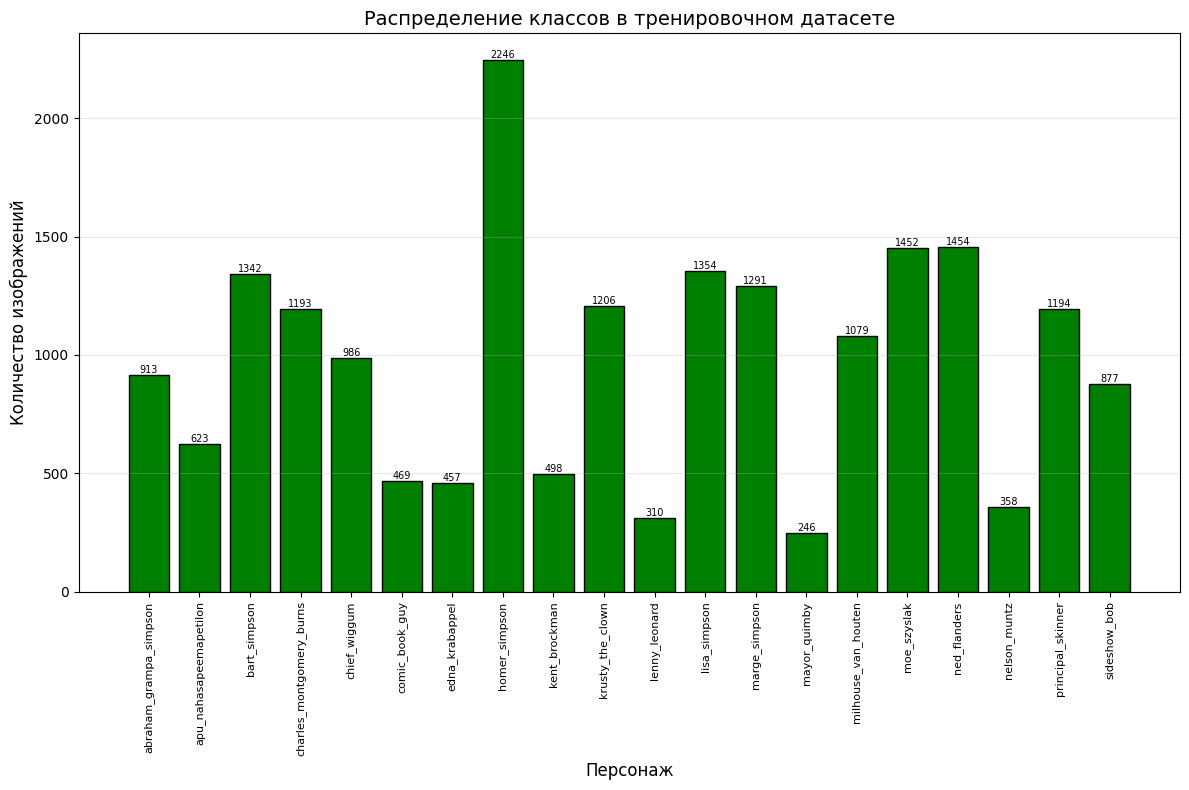

In [9]:
from collections import defaultdict

class_statistics = defaultdict(int)

for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_statistics[class_name] = len(files)

class_statistics =  dict(sorted(class_statistics.items()))

plt.figure(figsize=(12, 8))
bars = plt.bar(class_statistics.keys(), class_statistics.values(), color='green', edgecolor='black')
plt.bar_label(bars, labels=class_statistics.values(), fontsize=7)
plt.xticks(rotation=90, fontsize=8)
plt.title('Распределение классов в тренировочном датасете', fontsize=14)
plt.ylabel('Количество изображений', fontsize=12)
plt.xlabel('Персонаж', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Датасет сильно несбалансирован по классам. Например, класс mayor_quimby составляет примерно 0.1 от класса homer_simpson, что при обучении модели будет играть роль. Поэтому из всего тренировочного датасета возьмем только по 200-600 изображений каждого класса, чтобы распределение было чуть равномернее, дабы не создавать ситуации, когда модель хорошо определяет только самые объемные по количеству картинок классы исходного датасета.

Посмотрим, изображения какого размера содержатся в тренировочном датасете. Посмотрим, одинаковый ли у них размер.

In [10]:
from PIL import Image

def get_params_image(path):
    try:
        with Image.open(path) as img:
            return img.size, img.mode 
    except Exception as e:
        return None, str(e)

sizes = set()
modes = set()
for class_name in list(class_statistics.keys())[:5]:  
    class_path = os.path.join(train_path, class_name)
    for img_name in os.listdir(class_path)[:3]: 
        size, mode = get_params_image(os.path.join(class_path, img_name))
        sizes.add(size)
        modes.add(mode)

print(f"Размеры: {sizes}")
print(f"Цветовые режимы: {modes}")

Размеры: {(320, 480), (640, 480), (288, 400), (312, 352), (288, 432), (576, 416), (576, 432)}
Цветовые режимы: {'RGB'}


В тренировочных данных лежат изображения различных размеров, поэтому далее будет необходимо выполнить resize изображений и в трейне, и в тесте, чтобы они были одинаковые.

**1.2  Реализуйте код обучения модели, включающий чтение и подготовку данных (data loader), train loop с валидацией, логирование лосса и валидационных метрик в tensorboard.**


Напишем класс SimpsonsTestDataset для тестового набора данных, так как он имеет структуру, отличную от тренировочного датасета, который удобно обрабатывать с помощью ImageFolder.

In [11]:
class SimpsonsTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.classes = sorted(list(set([self._get_class_name(f) for f in self.image_files])))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def _get_class_name(self, filename):
        return '_'.join(filename.rsplit('.', 1)[0].split('_')[:-1])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        class_name = self._get_class_name(img_name)
        label = self.class_to_idx[class_name]

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [12]:
import random
from torch.utils.data import Subset

train_path = '/kaggle/input/simpsons/train_dataset'
test_path = '/kaggle/input/simpsons/test_dataset'

transform = transforms.Compose([
    transforms.Resize((128, 128)),        
    transforms.ToTensor(),                  
    transforms.Normalize(                  
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train = datasets.ImageFolder(root=train_path, transform=transform)

class_indices = defaultdict(list) #как говорилось выше, будем использовать не весь датасет, а только часть.
for idx, (_, target) in enumerate(train):
    class_indices[target].append(idx)
selected_indices = []
for cls, indices in class_indices.items():
    count = len(indices)
    if count < 600:
        selected_indices.extend(indices)
    else:
        sample_size = random.randint(500, 600)
        sampled = random.sample(indices, sample_size)
        selected_indices.extend(sampled)

balanced_train = Subset(train, selected_indices)
test = SimpsonsTestDataset(root_dir=test_path, transform=transform)

In [13]:
batch_size = 32
train_loader = DataLoader(balanced_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

print("Классы:", test.classes)
print("Количество классов:", len(train.classes))
print("Размер тренировочной выборки:", len(balanced_train))
print("Размер тестовой выборки:", len(test))

Классы: ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy', 'edna_krabappel', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lisa_simpson', 'marge_simpson', 'mayor_quimby', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'principal_skinner', 'sideshow_bob']
Количество классов: 20
Размер тренировочной выборки: 10235
Размер тестовой выборки: 990


In [8]:
images, labels = next(iter(train_loader))

print("Размерность тензора изображений:", images.shape)
print("Тип данных:", images.dtype)

Размерность тензора изображений: torch.Size([32, 3, 128, 128])
Тип данных: torch.float32


Изображение 0: метка=14, имя класса=milhouse_van_houten


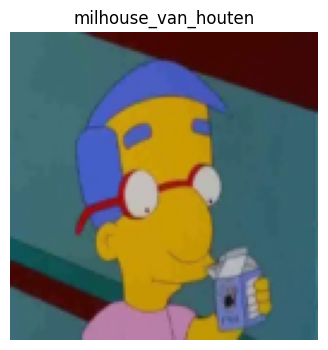

Изображение 1: метка=1, имя класса=apu_nahasapeemapetilon


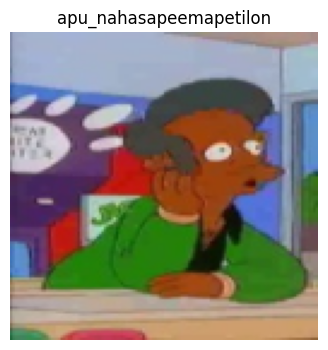

Изображение 2: метка=9, имя класса=krusty_the_clown


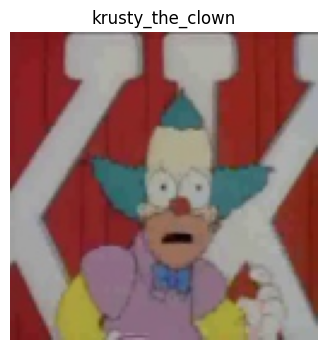

Изображение 3: метка=10, имя класса=lenny_leonard


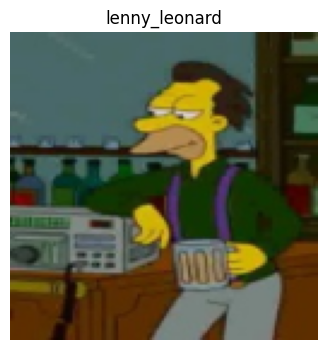

Изображение 4: метка=12, имя класса=marge_simpson


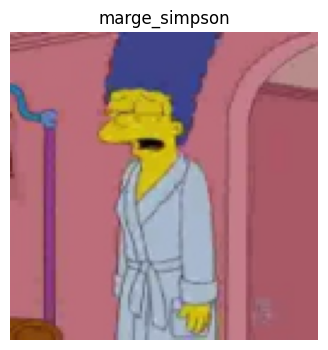

In [9]:
import matplotlib.pyplot as plt

for i in range(5):
    img, label = test[i]
    class_name = test.classes[label]
    
    print(f"Изображение {i}: метка={label}, имя класса={class_name}")
    

    mean = torch.tensor([0.485, 0.456, 0.406]).to(img.device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(img.device)
    
    img_unnorm = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
    img_unnorm = img_unnorm.cpu()

    plt.figure(figsize=(4, 4))
    plt.imshow(img_unnorm.permute(1, 2, 0).clamp(0, 1))  
    plt.title(class_name, fontsize=12)
    plt.axis('off')
    plt.show()

In [34]:
from sklearn.metrics import accuracy_score

def train(model, name_model, device, train_loader, test_loader, epochs, optimizer, criterion, writer):
    start_time = time.time()
    print(device)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    model.train()
    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
    EPOCHS = epochs
    y_true = []
    y_pred = []
    for epoch in tqdm(range(EPOCHS)):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.cuda())
            pred = output.argmax(dim=1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            y_pred.extend(pred.detach().cpu().numpy())
            y_true.extend(target.cpu().numpy())

        scheduler.step()
        
        train_acc.append(accuracy_score(y_true, y_pred))
        train_losses.append(running_loss / len(train_loader))

        
        model.eval()
        loss = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                loss += criterion(output, target).item()
                y_true.extend(target.cpu().numpy())
                y_pred.extend(pred.detach().cpu().numpy())

        
        test_losses.append(loss / len(test_loader))
        test_acc.append(accuracy_score(y_true, y_pred))
        if (epoch+1)%2==0 or epoch+1==EPOCHS:
            print(f'Epoch [{epoch+1}/{epochs}] '
                f'Train Loss: {train_losses[-1]:.4f}, Acc: {train_acc[-1]:.2f} | '
                f'Test Loss: {test_losses[-1]:.4f}, Acc: {test_acc[-1]:.2f}')
            
        writer.add_scalar('Loss/train',train_losses[-1] , epoch)
        writer.add_scalar('Loss/test', test_losses[-1], epoch)
        writer.add_scalar('Accuracy/train', train_acc[-1], epoch)
        writer.add_scalar('Accuracy/test', test_acc[-1], epoch)
            
    end_time = time.time()
    result_time = end_time - start_time
    print(f"Обучение заняло: {result_time:.2f} секунд или: {result_time / 60:.2f} минут")

    writer.close()

    plt.figure(figsize=(7, 3))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(name_model)
    plt.legend()
    
    plt.figure(figsize=(7, 3))
    plt.plot(train_acc, label='Train accuracy')
    plt.plot(test_acc, label='Test accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy_score')
    plt.title(name_model)
    plt.legend()
    plt.show()



In [14]:
def evaluate(model, device, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.detach().cpu().numpy())

    return(f"Accuracy на тестовых данных: {accuracy_score(y_true, y_pred):.2f}")

**1.3  Реализуйте и обучите линейную модель. Визуализируйте веса для каждого класса, прокомментируйте увиденное.**

In [16]:
class LinearModel(nn.Module):
    def __init__(self, num_classes, input_size=(3, 128, 128)):
        super().__init__()
        self.num_features = input_size[0] * input_size[1] * input_size[2]
        self.fc = nn.Linear(self.num_features, num_classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.fc(x)            
        return x

In [20]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='runs/simpsons_experiment_linearmodel')
#если вылезает warning, запустить повторно
# если вылезает ошибка, связанная с circular import, перезапустить сессию

In [18]:
model = LinearModel(num_classes=20).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

cuda


 10%|█         | 2/20 [01:19<12:02, 40.13s/it]

Epoch [2/20] Train Loss: 13.8676, Acc: 0.38 | Test Loss: 13.7126, Acc: 0.41


 20%|██        | 4/20 [02:40<10:44, 40.29s/it]

Epoch [4/20] Train Loss: 10.5640, Acc: 0.50 | Test Loss: 11.8486, Acc: 0.51


 30%|███       | 6/20 [03:59<09:16, 39.72s/it]

Epoch [6/20] Train Loss: 8.4566, Acc: 0.57 | Test Loss: 14.7020, Acc: 0.49


 40%|████      | 8/20 [05:18<07:56, 39.72s/it]

Epoch [8/20] Train Loss: 7.1060, Acc: 0.62 | Test Loss: 13.6477, Acc: 0.50


 50%|█████     | 10/20 [06:39<06:39, 39.91s/it]

Epoch [10/20] Train Loss: 6.3051, Acc: 0.66 | Test Loss: 11.1429, Acc: 0.59


 60%|██████    | 12/20 [07:57<05:17, 39.67s/it]

Epoch [12/20] Train Loss: 1.4207, Acc: 0.85 | Test Loss: 7.9646, Acc: 0.68


 70%|███████   | 14/20 [09:16<03:57, 39.50s/it]

Epoch [14/20] Train Loss: 1.1878, Acc: 0.86 | Test Loss: 7.6685, Acc: 0.69


 80%|████████  | 16/20 [10:36<02:38, 39.62s/it]

Epoch [16/20] Train Loss: 1.2575, Acc: 0.85 | Test Loss: 8.4905, Acc: 0.66


 90%|█████████ | 18/20 [11:56<01:19, 39.83s/it]

Epoch [18/20] Train Loss: 1.3969, Acc: 0.85 | Test Loss: 7.5794, Acc: 0.69


100%|██████████| 20/20 [13:17<00:00, 39.86s/it]

Epoch [20/20] Train Loss: 1.2068, Acc: 0.86 | Test Loss: 8.3171, Acc: 0.68
Обучение заняло: 797.13 секунд или: 13.29 минут


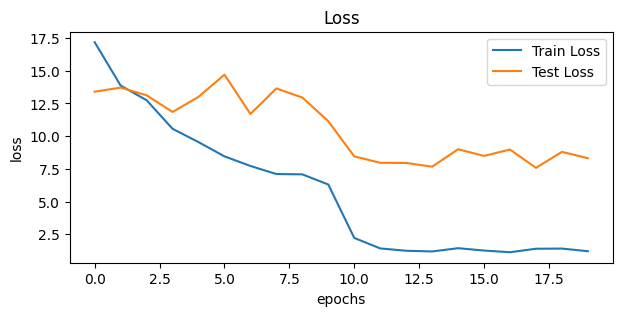

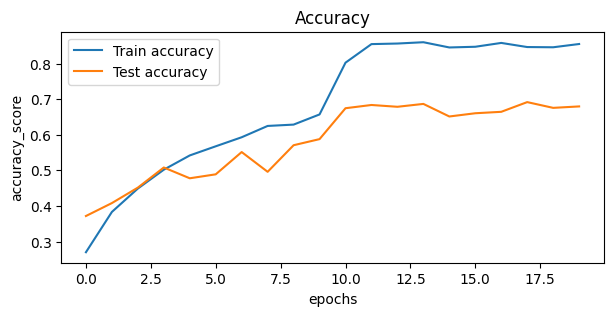

In [19]:
train(model, 'LinearModel', device, train_loader, test_loader, 20, optimizer, criterion, writer)

In [22]:
evaluate(model, device, test_loader)

'Accuracy на тестовых данных: 0.68'

In [23]:
torch.save(model.state_dict(), 'simpsons_LinearModel.pth')

In [24]:
def visualize_weights(weights, class_names, n_cols=5):
    num_classes = len(class_names)
    n_rows = (num_classes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    axes = axes.ravel()

    for i in range(num_classes):
        w = weights[i].reshape(3, 128, 128)  

        w_min, w_max = w.min(), w.max()
        w_normalized = (w - w_min) / (w_max - w_min)
        
        ax = axes[i]
        ax.imshow(w_normalized.transpose(1, 2, 0)) 
        ax.set_title(class_names[i], fontsize=8)
        ax.axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

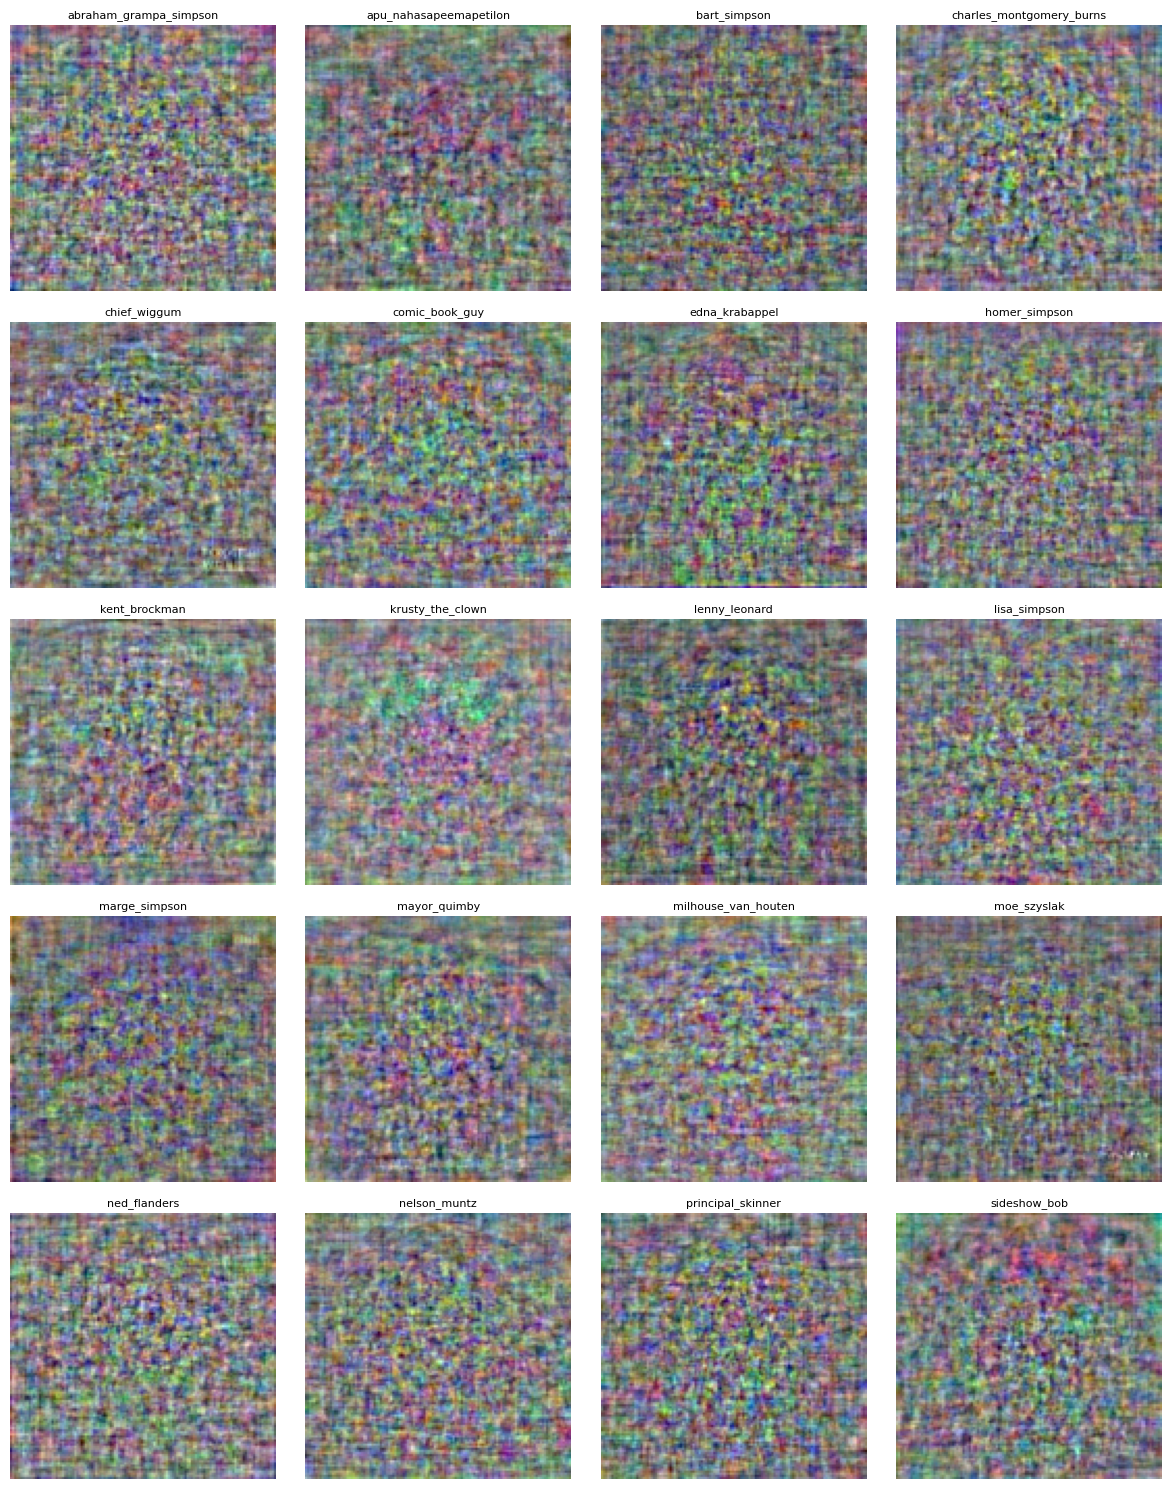

In [25]:
model.eval()
weights = model.fc.weight.data.cpu().numpy()
class_names = test.classes
visualize_weights(weights, class_names, n_cols=4)

На большинстве классов сложно увидеть какие-то выделенные признаки, но вот например у marge_simpson явно прослеживается синяя область вверху картинки, что объясняется тем, что у данного персонажа высокая прическа и синие волосы. Также можно заметить скопление оранжевых (коричневых?) точек вверху картинки sideshow_bob. У данного персонажа волосы такого цвета.

**1.4  Реализуйте и обучите MLP с 2-3 скрытыми слоями. Добавьте Dropout и проведите эксперименты с несколькими значения параметра p. Сравните качество и скорость обучения.**

In [26]:
class MLP(nn.Module):
    def __init__(self, num_classes, p_input, input_size=(3, 128, 128)):
        super().__init__()
        self.num_features = input_size[0] * input_size[1] * input_size[2]
        self.fc1 = nn.Linear(self.num_features, 128)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(p=p_input)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.ac1(self.fc1(x))
        x = self.ac2(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Будем использовать такие значения p в dropout: 0.5, 0.3, 0.2, 0.1.

cuda


 10%|█         | 2/20 [01:21<12:10, 40.57s/it]

Epoch [2/20] Train Loss: 2.4821, Acc: 0.26 | Test Loss: 2.3377, Acc: 0.31


 20%|██        | 4/20 [02:43<10:55, 40.94s/it]

Epoch [4/20] Train Loss: 1.8785, Acc: 0.43 | Test Loss: 1.9646, Acc: 0.43


 30%|███       | 6/20 [04:04<09:29, 40.69s/it]

Epoch [6/20] Train Loss: 1.5217, Acc: 0.53 | Test Loss: 1.6537, Acc: 0.53


 40%|████      | 8/20 [05:25<08:05, 40.47s/it]

Epoch [8/20] Train Loss: 1.2894, Acc: 0.60 | Test Loss: 1.5072, Acc: 0.59


 50%|█████     | 10/20 [06:44<06:41, 40.12s/it]

Epoch [10/20] Train Loss: 1.1219, Acc: 0.65 | Test Loss: 1.4937, Acc: 0.60


 60%|██████    | 12/20 [08:07<05:25, 40.63s/it]

Epoch [12/20] Train Loss: 0.6999, Acc: 0.76 | Test Loss: 1.2789, Acc: 0.66


 70%|███████   | 14/20 [09:29<04:04, 40.82s/it]

Epoch [14/20] Train Loss: 0.5839, Acc: 0.80 | Test Loss: 1.3207, Acc: 0.70


 80%|████████  | 16/20 [10:48<02:41, 40.36s/it]

Epoch [16/20] Train Loss: 0.5059, Acc: 0.82 | Test Loss: 1.4161, Acc: 0.71


 90%|█████████ | 18/20 [12:08<01:19, 39.98s/it]

Epoch [18/20] Train Loss: 0.4455, Acc: 0.84 | Test Loss: 1.4545, Acc: 0.73


100%|██████████| 20/20 [13:27<00:00, 40.38s/it]

Epoch [20/20] Train Loss: 0.4310, Acc: 0.85 | Test Loss: 1.5352, Acc: 0.73
Обучение заняло: 807.61 секунд или: 13.46 минут


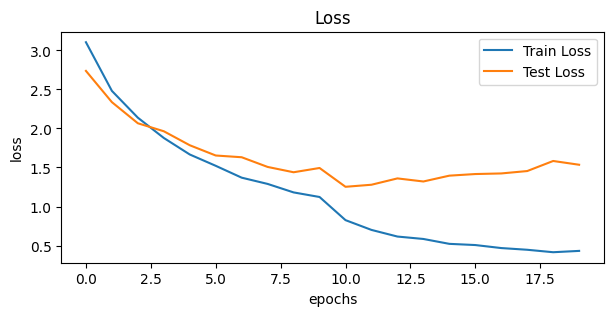

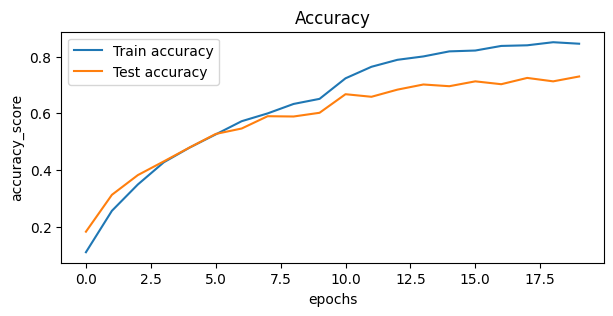

In [27]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_mlp05')
model_2 = MLP(num_classes=20, p_input=0.5).to(device)
optimizer = torch.optim.AdamW(model_2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
train(model_2, 'MLP with dropout, p=0.5', device, train_loader, test_loader, 20, optimizer, criterion, writer)
file_name = 'simpsons_MLP05.pth'
torch.save(model_2.state_dict(), file_name)

In [28]:
evaluate(model_2, device, test_loader)

'Accuracy на тестовых данных: 0.73'

Accuracy на тестовых данных составило 0.73 при значении p = 0.5. Будем сравнивать метрику в случаях с другими значениями p в dropout.

cuda


 10%|█         | 2/20 [01:27<13:00, 43.35s/it]

Epoch [2/20] Train Loss: 2.4009, Acc: 0.28 | Test Loss: 2.2633, Acc: 0.33


 20%|██        | 4/20 [02:51<11:20, 42.54s/it]

Epoch [4/20] Train Loss: 1.8176, Acc: 0.44 | Test Loss: 1.8326, Acc: 0.46


 30%|███       | 6/20 [04:22<10:18, 44.21s/it]

Epoch [6/20] Train Loss: 1.4953, Acc: 0.53 | Test Loss: 1.6493, Acc: 0.53


 40%|████      | 8/20 [05:50<08:45, 43.78s/it]

Epoch [8/20] Train Loss: 1.2538, Acc: 0.60 | Test Loss: 1.5877, Acc: 0.56


 50%|█████     | 10/20 [07:12<07:03, 42.32s/it]

Epoch [10/20] Train Loss: 1.1303, Acc: 0.64 | Test Loss: 1.4646, Acc: 0.59


 60%|██████    | 12/20 [08:33<05:32, 41.51s/it]

Epoch [12/20] Train Loss: 0.7275, Acc: 0.75 | Test Loss: 1.2827, Acc: 0.68


 70%|███████   | 14/20 [09:55<04:06, 41.14s/it]

Epoch [14/20] Train Loss: 0.5858, Acc: 0.80 | Test Loss: 1.3815, Acc: 0.69


 80%|████████  | 16/20 [11:16<02:43, 40.80s/it]

Epoch [16/20] Train Loss: 0.5307, Acc: 0.82 | Test Loss: 1.3771, Acc: 0.73


 90%|█████████ | 18/20 [12:37<01:21, 40.74s/it]

Epoch [18/20] Train Loss: 0.4997, Acc: 0.82 | Test Loss: 1.4428, Acc: 0.71


100%|██████████| 20/20 [13:59<00:00, 41.96s/it]

Epoch [20/20] Train Loss: 0.4425, Acc: 0.84 | Test Loss: 1.5325, Acc: 0.73
Обучение заняло: 839.30 секунд или: 13.99 минут


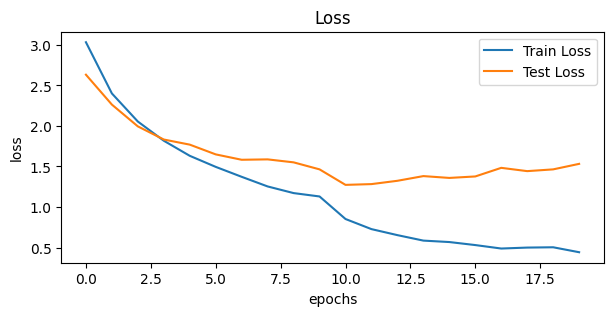

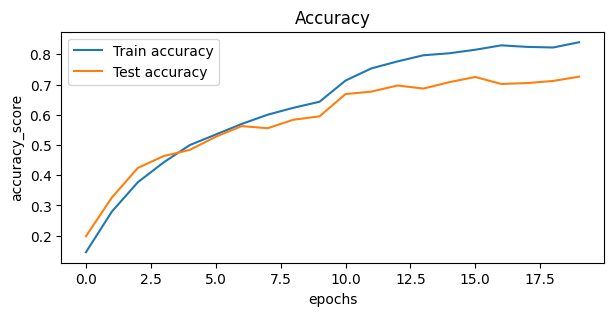

In [29]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_mlp03')
model_3 = MLP(num_classes=20, p_input=0.3).to(device)
optimizer = torch.optim.AdamW(model_3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
train(model_3, 'MLP with dropout, p=0.3', device, train_loader, test_loader, 20, optimizer, criterion, writer)
file_name = 'simpsons_MLP03.pth'
torch.save(model_3.state_dict(), file_name)

In [30]:
evaluate(model_3, device, test_loader)

'Accuracy на тестовых данных: 0.73'

При уменьшении значения p accuracy не изменилась.

cuda


 10%|█         | 2/20 [01:42<14:49, 49.40s/it]

Epoch [2/20] Train Loss: 2.2944, Acc: 0.32 | Test Loss: 2.1506, Acc: 0.37


 20%|██        | 4/20 [03:06<11:51, 44.50s/it]

Epoch [4/20] Train Loss: 1.7068, Acc: 0.48 | Test Loss: 1.8660, Acc: 0.49


 30%|███       | 6/20 [04:27<09:47, 41.99s/it]

Epoch [6/20] Train Loss: 1.4096, Acc: 0.57 | Test Loss: 1.5579, Acc: 0.57


 40%|████      | 8/20 [05:46<08:07, 40.64s/it]

Epoch [8/20] Train Loss: 1.1717, Acc: 0.63 | Test Loss: 1.4109, Acc: 0.61


 50%|█████     | 10/20 [07:04<06:38, 39.88s/it]

Epoch [10/20] Train Loss: 0.9821, Acc: 0.69 | Test Loss: 1.4753, Acc: 0.61


 60%|██████    | 12/20 [08:24<05:19, 39.90s/it]

Epoch [12/20] Train Loss: 0.6053, Acc: 0.80 | Test Loss: 1.2082, Acc: 0.71


 70%|███████   | 14/20 [09:45<04:01, 40.24s/it]

Epoch [14/20] Train Loss: 0.4868, Acc: 0.83 | Test Loss: 1.1741, Acc: 0.72


 80%|████████  | 16/20 [11:06<02:40, 40.20s/it]

Epoch [16/20] Train Loss: 0.4471, Acc: 0.84 | Test Loss: 1.3596, Acc: 0.73


 90%|█████████ | 18/20 [12:25<01:20, 40.07s/it]

Epoch [18/20] Train Loss: 0.4149, Acc: 0.85 | Test Loss: 1.3465, Acc: 0.73


100%|██████████| 20/20 [13:44<00:00, 41.22s/it]

Epoch [20/20] Train Loss: 0.3784, Acc: 0.87 | Test Loss: 1.4043, Acc: 0.75
Обучение заняло: 824.45 секунд или: 13.74 минут


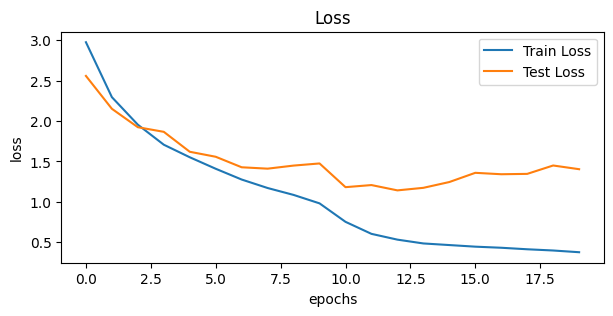

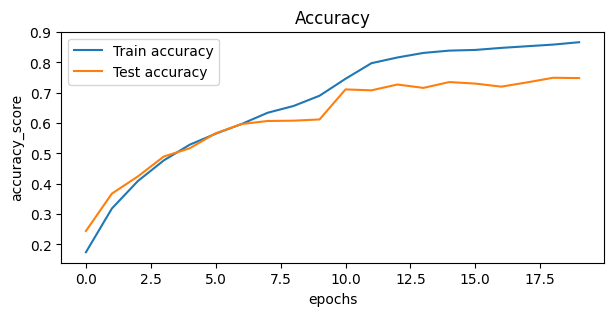

In [31]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_mlp02')
model_4 = MLP(num_classes=20, p_input=0.2).to(device)
optimizer = torch.optim.AdamW(model_4.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
train(model_4, 'MLP with dropout, p=0.2', device, train_loader, test_loader, 20, optimizer, criterion, writer)
file_name = 'simpsons_MLP02.pth'
torch.save(model_4.state_dict(), file_name)

In [32]:
evaluate(model_4, device, test_loader)

'Accuracy на тестовых данных: 0.75'

При уменьшении p accuracy выросла до 0.75 (было 0.73).

cuda


 10%|█         | 2/20 [01:39<14:29, 48.29s/it]

Epoch [2/20] Train Loss: 2.1926, Acc: 0.34 | Test Loss: 2.1672, Acc: 0.37


 20%|██        | 4/20 [03:00<11:27, 42.99s/it]

Epoch [4/20] Train Loss: 1.6789, Acc: 0.48 | Test Loss: 1.7547, Acc: 0.48


 30%|███       | 6/20 [04:28<10:07, 43.40s/it]

Epoch [6/20] Train Loss: 1.3393, Acc: 0.59 | Test Loss: 1.5995, Acc: 0.55


 40%|████      | 8/20 [05:53<08:33, 42.80s/it]

Epoch [8/20] Train Loss: 1.1701, Acc: 0.63 | Test Loss: 1.4975, Acc: 0.60


 50%|█████     | 10/20 [07:17<07:04, 42.47s/it]

Epoch [10/20] Train Loss: 1.0325, Acc: 0.68 | Test Loss: 1.5083, Acc: 0.61


 60%|██████    | 12/20 [08:41<05:36, 42.11s/it]

Epoch [12/20] Train Loss: 0.5968, Acc: 0.79 | Test Loss: 1.3181, Acc: 0.71


 70%|███████   | 14/20 [10:03<04:09, 41.54s/it]

Epoch [14/20] Train Loss: 0.5069, Acc: 0.82 | Test Loss: 1.4031, Acc: 0.71


 80%|████████  | 16/20 [11:24<02:44, 41.06s/it]

Epoch [16/20] Train Loss: 0.4649, Acc: 0.84 | Test Loss: 1.4481, Acc: 0.71


 90%|█████████ | 18/20 [12:45<01:21, 40.81s/it]

Epoch [18/20] Train Loss: 0.4254, Acc: 0.85 | Test Loss: 1.5748, Acc: 0.72


100%|██████████| 20/20 [14:09<00:00, 42.47s/it]

Epoch [20/20] Train Loss: 0.3822, Acc: 0.86 | Test Loss: 1.5561, Acc: 0.74
Обучение заняло: 849.37 секунд или: 14.16 минут


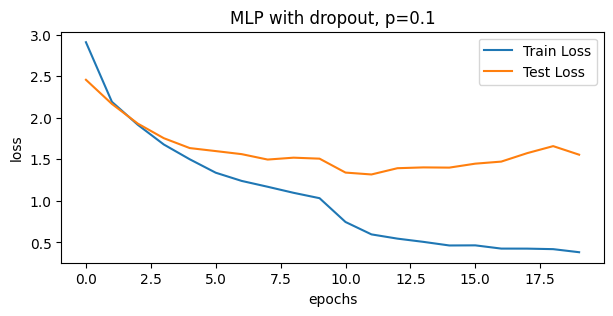

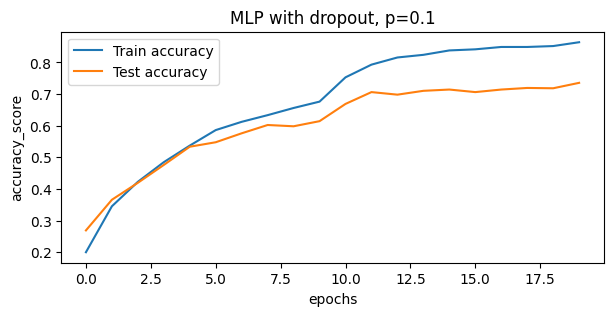

In [35]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_mlp01')
model_5 = MLP(num_classes=20, p_input=0.1).to(device)
optimizer = torch.optim.AdamW(model_5.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
train(model_5, 'MLP with dropout, p=0.1', device, train_loader, test_loader, 20, optimizer, criterion, writer)
file_name = 'simpsons_MLP01.pth'
torch.save(model_5.state_dict(), file_name)

In [37]:
evaluate(model_5, device, test_loader)

'Accuracy на тестовых данных: 0.74'

 p = 0.1, accuracy = 0.74. По сравнению с предыдущим случаем значение метрики уменьшилось на 0.01, но accuracy все равно лучше чем при p = 0.5 и p = 0.3.

По итогу экспериментов с различным значением параметра p в слое dropout можно заметить, что в общем модель лучше классифицирует изображения при уменьшении значения p. Это может объясняться тем (это мое предположение), что dropout полезен в больших и сложных моделях, когда нам нужно найти очень много разных зависимостей и выявить много каких-то фичей, а потом просто убирать часть не очень значительных. В нашем же случае модель достаточно простая, не выявляет так много признаков, не очень хорошо классифицирует изображения (accuracy имеет значения в районе 0.7), а dropout c большими значениями параметра p только усуглубляет ситуацию, отключая некоторые нейроны, тем самым уменьшая количество фичей, которые выявила и так не самая сложная модель. Скорость обучения моделей при различных значениях p примерно одна и та же. Если сравнивать модели с несколькими скрытими слоями и dropout с линейной моделью, вторая явно проигрывает по качеству обучения и скорости.

# Часть 2 (5 баллов)

**2.1  Реализуйте и обучите сверточную модель:
Input(128x128x3) -> Conv(3x3, 16) -> Conv(3x3, 16) -> MAX POOL (2x2) -> Conv(3x3, 32) -> Conv(3x3, 32) -> MAX POOL (2x2) -> Conv(3x3, 64) -> Conv(3x3, 64) -> MAX POOL (2x2) -> FC(4096) -> FC
Все свертки с pad=1, stride=1; pooling со stride=2. Функция активации ReLU.**

In [45]:
class CNN(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                  nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fclayer = nn.Sequential(nn.Flatten(), nn.Linear(16 * 16 * 64, 4096), nn.ReLU(), 
                                     nn.Linear(4096, num_classes))
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fclayer(x)
        return x

m = CNN()
print(f"Количество обучаемых параметров модели: {sum([p.numel() for p in m.parameters() if p.requires_grad])}")

Количество обучаемых параметров модели: 67266980


Немного перепишем функцию train.

In [15]:
from sklearn.metrics import accuracy_score
def train_model(model, device, train_loader, test_loader, epochs, optimizer, criterion, writer):
    start_time = time.time()
    print(device)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    model.train()
    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
    EPOCHS = epochs
    y_true = []
    y_pred = []
    for epoch in tqdm(range(EPOCHS)):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.cuda())
            pred = output.argmax(dim=1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            y_pred.extend(pred.detach().cpu().numpy())
            y_true.extend(target.cpu().numpy())

        scheduler.step()
        
        train_acc.append(accuracy_score(y_true, y_pred))
        train_losses.append(running_loss / len(train_loader))

        
        model.eval()
        loss = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                loss += criterion(output, target).item()
                y_true.extend(target.cpu().numpy())
                y_pred.extend(pred.detach().cpu().numpy())

        
        test_losses.append(loss / len(test_loader))
        test_acc.append(accuracy_score(y_true, y_pred))
        if (epoch+1)%2==0 or epoch+1==EPOCHS:
            print(f'Epoch [{epoch+1}/{epochs}] '
                f'Train Loss: {train_losses[-1]:.4f}, Acc: {train_acc[-1]:.2f} | '
                f'Test Loss: {test_losses[-1]:.4f}, Acc: {test_acc[-1]:.2f}')
            
        writer.add_scalar('Loss/train',train_losses[-1] , epoch)
        writer.add_scalar('Loss/test', test_losses[-1], epoch)
        writer.add_scalar('Accuracy/train', train_acc[-1], epoch)
        writer.add_scalar('Accuracy/test', test_acc[-1], epoch)

        for name, param in model.named_parameters():
            writer.add_histogram(f"params/{name}", param.detach().cpu().numpy(), epoch)
            
    end_time = time.time()
    result_time = end_time - start_time
    print(f"Обучение заняло: {result_time:.2f} секунд или: {result_time / 60:.2f} минут")

    writer.close()
    
    return train_losses, test_losses, train_acc, test_acc

In [16]:
def plot_charts(model_name, train_losses, test_losses, train_acc, test_acc):
    plt.figure(figsize=(7, 3))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(model_name)
    plt.legend()
    
    plt.figure(figsize=(7, 3))
    plt.plot(train_acc, label='Train accuracy')
    plt.plot(test_acc, label='Test accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy_score')
    plt.title(model_name)
    plt.legend()
    plt.show()

In [48]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_cnn')
model_cnn = CNN().to(device)
optimizer = torch.optim.AdamW(model_cnn.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss().to(device)
tr_l_cnn, t_l_cnn, tr_acc_cnn, t_acc_cnn = train_model(model_cnn, device, train_loader, test_loader, 16, optimizer, criterion, writer)
file_name = 'simpsons_cnn.pth'
torch.save(model_cnn.state_dict(), file_name)

cuda


  6%|▋         | 1/16 [01:02<15:31, 62.11s/it]

Epoch [2/16] Train Loss: 1.6680, Acc: 0.52 | Test Loss: 1.5001, Acc: 0.58


 19%|█▉        | 3/16 [02:42<11:28, 52.99s/it]

Epoch [4/16] Train Loss: 0.9994, Acc: 0.71 | Test Loss: 0.9684, Acc: 0.73


 31%|███▏      | 5/16 [04:23<09:24, 51.35s/it]

Epoch [6/16] Train Loss: 0.4263, Acc: 0.87 | Test Loss: 0.7191, Acc: 0.82


 44%|████▍     | 7/16 [06:04<07:39, 51.01s/it]

Epoch [8/16] Train Loss: 0.1079, Acc: 0.96 | Test Loss: 0.7521, Acc: 0.86


 56%|█████▋    | 9/16 [07:50<06:04, 52.08s/it]

Epoch [10/16] Train Loss: 0.0483, Acc: 0.97 | Test Loss: 0.9334, Acc: 0.86


 69%|██████▉   | 11/16 [09:37<04:22, 52.58s/it]

Epoch [12/16] Train Loss: 0.0056, Acc: 0.99 | Test Loss: 0.8574, Acc: 0.88


 81%|████████▏ | 13/16 [11:20<02:36, 52.15s/it]

Epoch [14/16] Train Loss: 0.0042, Acc: 0.99 | Test Loss: 0.9047, Acc: 0.88


 94%|█████████▍| 15/16 [13:03<00:51, 51.64s/it]

Epoch [16/16] Train Loss: 0.0016, Acc: 0.99 | Test Loss: 0.9439, Acc: 0.88


100%|██████████| 16/16 [13:52<00:00, 52.05s/it]


Обучение заняло: 832.82 секунд или: 13.88 минут


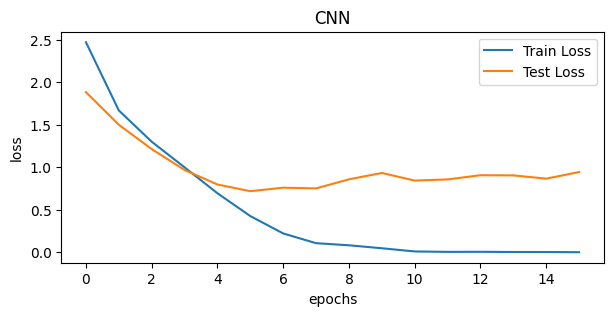

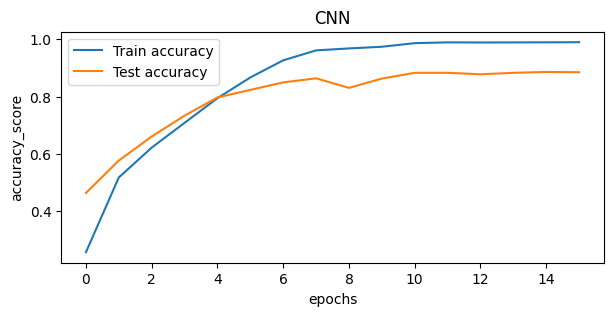

In [51]:
plot_charts('CNN', tr_l_cnn, t_l_cnn, tr_acc_cnn, t_acc_cnn)

При бОльшем количестве эпох модель уже начинает переобучаться (лосс на трене становится 0, а на тесте потихоньку растет, при этом accuracy  на тесте не растет).

In [52]:
evaluate(model_cnn, device, test_loader)

'Accuracy на тестовых данных: 0.88'

**2.2  Увеличьте модель в глубину (число сверточных слоев) и в ширину (размер сверточных слоев) так, чтобы число параметров было примерно равным для обеих моделей. Оцените, как меняется качество и скорость обучения относительной базовой модели из пункта 2.1.**

Добавим в модель еще несколько сверточных слоев.

In [53]:
class CNNDeep(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                  nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                  nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fclayer = nn.Sequential(nn.Flatten(), nn.Linear(16 * 16 * 64, 4096), nn.ReLU(), 
                                     nn.Linear(4096, num_classes))
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fclayer(x)
        return x

        
m = CNNDeep()
print(f"Количество обучаемых параметров модели: {sum([p.numel() for p in m.parameters() if p.requires_grad])}")

Количество обучаемых параметров модели: 67315476


In [54]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_cnnd')
model_cnnd = CNNDeep().to(device)
optimizer = torch.optim.AdamW(model_cnnd.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss().to(device)
tr_l_cnnd, t_l_cnnd, tr_acc_cnnd, t_acc_cnnd = train_model(model_cnnd, device, train_loader, test_loader, 16, optimizer, criterion, writer)
file_name = 'simpsons_cnnd.pth'
torch.save(model_cnnd.state_dict(), file_name)

cuda


  6%|▋         | 1/16 [00:57<14:15, 57.06s/it]

Epoch [2/16] Train Loss: 2.2375, Acc: 0.33 | Test Loss: 1.9911, Acc: 0.42


 19%|█▉        | 3/16 [02:38<11:15, 51.97s/it]

Epoch [4/16] Train Loss: 1.1745, Acc: 0.65 | Test Loss: 1.0727, Acc: 0.70


 31%|███▏      | 5/16 [04:19<09:24, 51.29s/it]

Epoch [6/16] Train Loss: 0.2823, Acc: 0.91 | Test Loss: 0.7880, Acc: 0.84


 44%|████▍     | 7/16 [06:02<07:41, 51.23s/it]

Epoch [8/16] Train Loss: 0.0467, Acc: 0.98 | Test Loss: 1.0400, Acc: 0.85


 56%|█████▋    | 9/16 [07:43<05:56, 50.97s/it]

Epoch [10/16] Train Loss: 0.0404, Acc: 0.98 | Test Loss: 1.2071, Acc: 0.84


 69%|██████▉   | 11/16 [09:25<04:15, 51.06s/it]

Epoch [12/16] Train Loss: 0.0010, Acc: 0.99 | Test Loss: 1.2064, Acc: 0.86


 81%|████████▏ | 13/16 [11:17<02:40, 53.63s/it]

Epoch [14/16] Train Loss: 0.0003, Acc: 0.99 | Test Loss: 1.3093, Acc: 0.86


 94%|█████████▍| 15/16 [13:06<00:54, 54.03s/it]

Epoch [16/16] Train Loss: 0.0001, Acc: 0.99 | Test Loss: 1.3796, Acc: 0.86


100%|██████████| 16/16 [14:00<00:00, 52.51s/it]


Обучение заняло: 840.12 секунд или: 14.00 минут


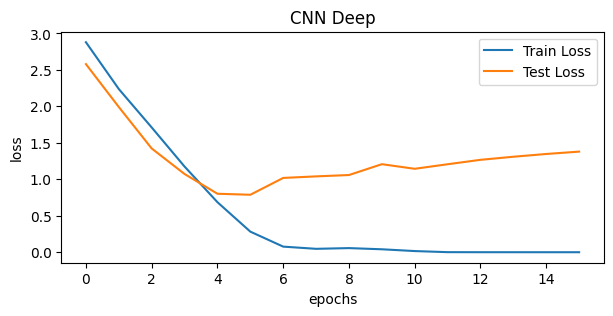

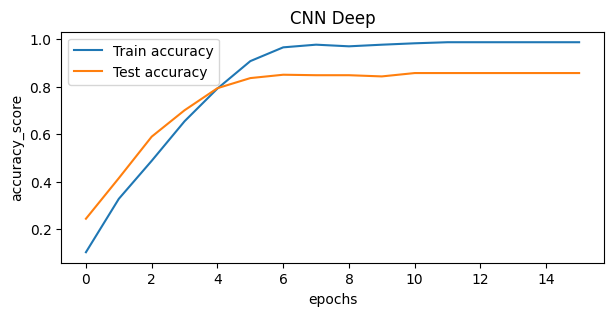

'Accuracy на тестовых данных: 0.86'

In [55]:
plot_charts('CNN Deep', tr_l_cnnd, t_l_cnnd, tr_acc_cnnd, t_acc_cnnd)
evaluate(model_cnnd, device, test_loader)

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(7, 9)) 

axes[0].plot(tr_l_cnn, label='CNN', color='blue')
axes[0].plot(tr_l_cnnd, label='CNNDeep', color='red')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('Train loss')
axes[0].set_title('CNN vs CNNDeep')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(t_l_cnn, label='CNN', color='blue')
axes[1].plot(t_l_cnnd, label='CNNDeep', color='red')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('Test loss')
axes[1].set_title('CNN vs CNNDeep')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t_acc_cnn, label='CNN', color='blue')
axes[2].plot(t_acc_cnnd, label='CNNDeep', color='red')
axes[2].set_xlabel('epochs')
axes[2].set_ylabel('Test accuracy')
axes[2].set_title('CNN vs CNNDeep')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()

Более глубокая модель обучается медленнее и имеет худшее качество.

Увеличим размер сверточных слоев.

In [56]:
class CNNWide(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                  nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(32, 48, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.Conv2d(48, 48, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(48, 96, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.Conv2d(96, 96, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fclayer = nn.Sequential(nn.Flatten(), nn.Linear(16 * 16 * 96, 2800), nn.ReLU(), 
                                     nn.Linear(2800, num_classes))
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fclayer(x)
        return x

m = CNNWide()
print(f"Количество обучаемых параметров модели: {sum([p.numel() for p in m.parameters() if p.requires_grad])}")

Количество обучаемых параметров модели: 69041028


In [57]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_cnnw')
model_cnnw = CNNWide().to(device)
optimizer = torch.optim.AdamW(model_cnnw.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss().to(device)
tr_l_cnnw, t_l_cnnw, tr_acc_cnnw, t_acc_cnnw = train_model(model_cnnw, device, train_loader, test_loader, 16, optimizer, criterion, writer)
file_name = 'simpsons_cnnw.pth'
torch.save(model_cnnw.state_dict(), file_name)

cuda


  6%|▋         | 1/16 [00:58<14:43, 58.91s/it]

Epoch [2/16] Train Loss: 1.4811, Acc: 0.57 | Test Loss: 1.2719, Acc: 0.65


 19%|█▉        | 3/16 [02:45<11:48, 54.48s/it]

Epoch [4/16] Train Loss: 0.6024, Acc: 0.82 | Test Loss: 0.7024, Acc: 0.80


 31%|███▏      | 5/16 [04:31<09:48, 53.51s/it]

Epoch [6/16] Train Loss: 0.0895, Acc: 0.96 | Test Loss: 0.6284, Acc: 0.87


 44%|████▍     | 7/16 [06:16<07:55, 52.80s/it]

Epoch [8/16] Train Loss: 0.0384, Acc: 0.98 | Test Loss: 0.6865, Acc: 0.88


 56%|█████▋    | 9/16 [08:01<06:09, 52.75s/it]

Epoch [10/16] Train Loss: 0.0249, Acc: 0.98 | Test Loss: 0.8238, Acc: 0.87


 69%|██████▉   | 11/16 [09:48<04:26, 53.24s/it]

Epoch [12/16] Train Loss: 0.0039, Acc: 0.99 | Test Loss: 0.7137, Acc: 0.89


 81%|████████▏ | 13/16 [11:36<02:40, 53.58s/it]

Epoch [14/16] Train Loss: 0.0018, Acc: 0.99 | Test Loss: 0.7400, Acc: 0.88


 94%|█████████▍| 15/16 [13:21<00:52, 52.88s/it]

Epoch [16/16] Train Loss: 0.0022, Acc: 0.99 | Test Loss: 0.7164, Acc: 0.89


100%|██████████| 16/16 [14:12<00:00, 53.31s/it]


Обучение заняло: 852.88 секунд или: 14.21 минут


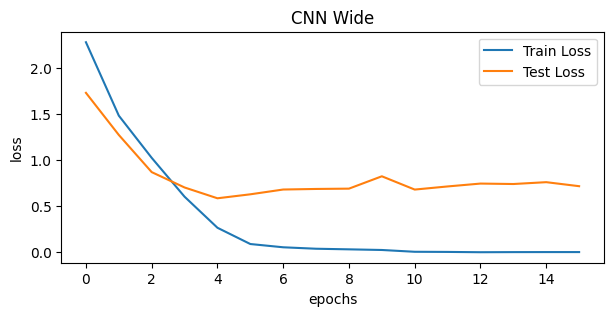

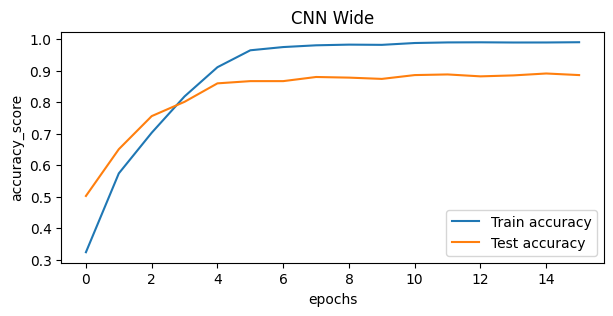

'Accuracy на тестовых данных: 0.89'

In [58]:
plot_charts('CNN Wide', tr_l_cnnw, t_l_cnnw, tr_acc_cnnw, t_acc_cnnw)
evaluate(model_cnnw, device, test_loader)

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(7, 9)) 

axes[0].plot(tr_l_cnn, label='CNN', color='blue')
axes[0].plot(tr_l_cnnw, label='CNNWide', color='red')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('Train loss')
axes[0].set_title('CNN vs CNNWide')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(t_l_cnn, label='CNN', color='blue')
axes[1].plot(t_l_cnnw, label='CNNWide', color='red')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('Test loss')
axes[1].set_title('CNN vs CNNWide')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(t_acc_cnn, label='CNN', color='blue')
axes[2].plot(t_acc_cnnw, label='CNNWide', color='red')
axes[2].set_xlabel('epochs')
axes[2].set_ylabel('Test accuracy')
axes[2].set_title('CNN vs CNNWide')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()

plt.show()

В результате экспериментов с архитектурой модели лучшей оказалась модель CNNWide.

**2.3  Для лучшей модели замените функцию активации на Tanh и SiLU, сравните результаты.**

Tanh:

In [59]:
class CNNWideTanh(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1), nn.Tanh(),
                                  nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1), nn.Tanh(),
                                  nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(32, 48, kernel_size=3, padding=1, stride=1), nn.Tanh(),
                                   nn.Conv2d(48, 48, kernel_size=3, padding=1, stride=1), nn.Tanh(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(48, 96, kernel_size=3, padding=1, stride=1), nn.Tanh(),
                                   nn.Conv2d(96, 96, kernel_size=3, padding=1, stride=1), nn.Tanh(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fclayer = nn.Sequential(nn.Flatten(), nn.Linear(16 * 16 * 96, 2800), nn.Tanh(), 
                                     nn.Linear(2800, num_classes))
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fclayer(x)
        return x

In [60]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_cnnwtanh')
model_cnnwtanh = CNNWideTanh().to(device)
optimizer = torch.optim.AdamW(model_cnnwtanh.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss().to(device)
tr_l_cnnwtanh, t_l_cnnwtanh, tr_acc_cnnwtanh, t_acc_cnnwtanh = train_model(model_cnnwtanh, device, train_loader, test_loader, 16, optimizer, criterion, writer)
file_name = 'simpsons_cnnwtanh.pth'
torch.save(model_cnnwtanh.state_dict(), file_name)

cuda


  6%|▋         | 1/16 [00:52<13:10, 52.69s/it]

Epoch [2/16] Train Loss: 1.5312, Acc: 0.57 | Test Loss: 1.2552, Acc: 0.65


 19%|█▉        | 3/16 [02:37<11:23, 52.57s/it]

Epoch [4/16] Train Loss: 0.7944, Acc: 0.77 | Test Loss: 0.9134, Acc: 0.76


 31%|███▏      | 5/16 [04:22<09:37, 52.48s/it]

Epoch [6/16] Train Loss: 0.2621, Acc: 0.92 | Test Loss: 0.7510, Acc: 0.84


 44%|████▍     | 7/16 [06:06<07:50, 52.29s/it]

Epoch [8/16] Train Loss: 0.0350, Acc: 0.98 | Test Loss: 0.7767, Acc: 0.86


 56%|█████▋    | 9/16 [07:51<06:05, 52.22s/it]

Epoch [10/16] Train Loss: 0.0050, Acc: 0.99 | Test Loss: 0.8341, Acc: 0.86


 69%|██████▉   | 11/16 [09:34<04:19, 51.85s/it]

Epoch [12/16] Train Loss: 0.0024, Acc: 0.99 | Test Loss: 0.8475, Acc: 0.86


 81%|████████▏ | 13/16 [11:22<02:39, 53.07s/it]

Epoch [14/16] Train Loss: 0.0017, Acc: 0.99 | Test Loss: 0.8694, Acc: 0.86


 94%|█████████▍| 15/16 [13:07<00:52, 52.67s/it]

Epoch [16/16] Train Loss: 0.0013, Acc: 0.99 | Test Loss: 0.8875, Acc: 0.86


100%|██████████| 16/16 [13:59<00:00, 52.45s/it]


Обучение заняло: 839.24 секунд или: 13.99 минут


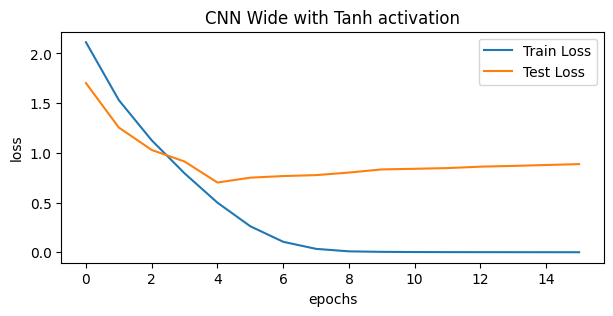

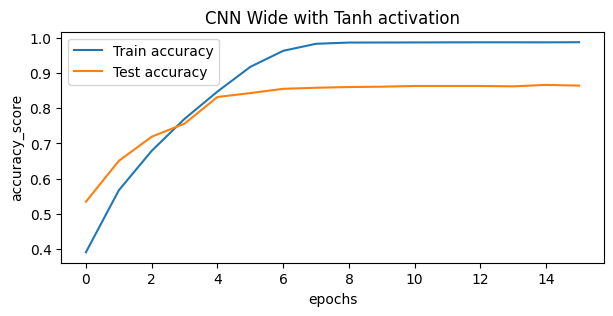

'Accuracy на тестовых данных: 0.86'

In [61]:
plot_charts('CNN Wide with Tanh activation', tr_l_cnnwtanh, t_l_cnnwtanh, tr_acc_cnnwtanh, t_acc_cnnwtanh)
evaluate(model_cnnwtanh, device, test_loader)

SiLU:

In [62]:
class CNNWideSiLU(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1), nn.SiLU(),
                                  nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1), nn.SiLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(32, 48, kernel_size=3, padding=1, stride=1), nn.SiLU(),
                                   nn.Conv2d(48, 48, kernel_size=3, padding=1, stride=1), nn.SiLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(48, 96, kernel_size=3, padding=1, stride=1), nn.SiLU(),
                                   nn.Conv2d(96, 96, kernel_size=3, padding=1, stride=1), nn.SiLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fclayer = nn.Sequential(nn.Flatten(), nn.Linear(16 * 16 * 96, 2800), nn.SiLU(), 
                                     nn.Linear(2800, num_classes))
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fclayer(x)
        return x

In [63]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_cnnwsilu')
model_cnnwsilu = CNNWideSiLU().to(device)
optimizer = torch.optim.AdamW(model_cnnwsilu.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss().to(device)
tr_l_cnnwsilu, t_l_cnnwsilu, tr_acc_cnnwsilu, t_acc_cnnwsilu = train_model(model_cnnwsilu, device, train_loader, test_loader, 16, optimizer, criterion, writer)
file_name = 'simpsons_cnnwsilu.pth'
torch.save(model_cnnwsilu.state_dict(), file_name)

cuda


  6%|▋         | 1/16 [00:52<13:01, 52.07s/it]

Epoch [2/16] Train Loss: 1.6601, Acc: 0.52 | Test Loss: 1.4054, Acc: 0.60


 19%|█▉        | 3/16 [02:37<11:20, 52.36s/it]

Epoch [4/16] Train Loss: 0.5461, Acc: 0.83 | Test Loss: 0.5713, Acc: 0.86


 31%|███▏      | 5/16 [04:22<09:37, 52.51s/it]

Epoch [6/16] Train Loss: 0.0490, Acc: 0.98 | Test Loss: 0.7086, Acc: 0.88


 44%|████▍     | 7/16 [06:07<07:52, 52.55s/it]

Epoch [8/16] Train Loss: 0.0211, Acc: 0.99 | Test Loss: 0.7032, Acc: 0.89


 56%|█████▋    | 9/16 [07:51<06:05, 52.18s/it]

Epoch [10/16] Train Loss: 0.0154, Acc: 0.99 | Test Loss: 0.8286, Acc: 0.88


 69%|██████▉   | 11/16 [09:34<04:20, 52.04s/it]

Epoch [12/16] Train Loss: 0.0012, Acc: 0.99 | Test Loss: 0.7668, Acc: 0.89


 81%|████████▏ | 13/16 [11:18<02:35, 51.80s/it]

Epoch [14/16] Train Loss: 0.0005, Acc: 0.99 | Test Loss: 0.8125, Acc: 0.89


 94%|█████████▍| 15/16 [13:03<00:52, 52.38s/it]

Epoch [16/16] Train Loss: 0.0006, Acc: 0.99 | Test Loss: 0.8433, Acc: 0.89


100%|██████████| 16/16 [13:56<00:00, 52.30s/it]


Обучение заняло: 836.77 секунд или: 13.95 минут


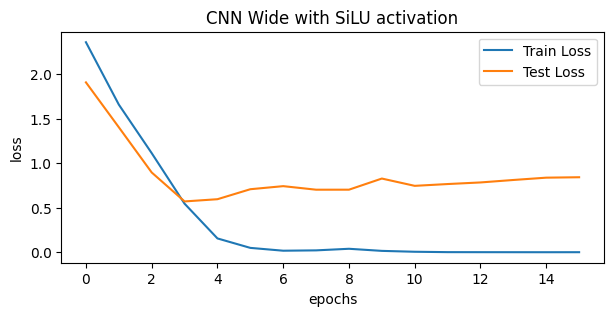

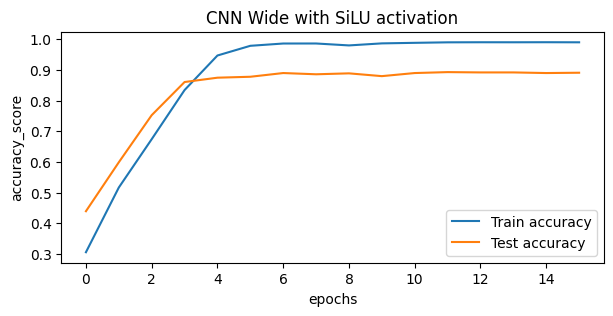

'Accuracy на тестовых данных: 0.89'

In [64]:
plot_charts('CNN Wide with SiLU activation', tr_l_cnnwsilu, t_l_cnnwsilu, tr_acc_cnnwsilu, t_acc_cnnwsilu)
evaluate(model_cnnwsilu, device, test_loader)

Модель CNNWide с функцией активации SiLU  имеет более высокую accuracy, чем та же модель с функциями активации Tanh. Тем не менее, качество работы модели с SiLU и с ReLU одинаковое.

**2.4  Добавьте в модель слой нормализации. Проведите эксперименты с BatchNorm и GroupNorm при различных размерах батча (от 2 до 32 с шагом на ваш выбор).**

In [35]:
class CNNBatchNorm(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),nn.BatchNorm2d(16), nn.ReLU(),
                                  nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=1),nn.BatchNorm2d(16), nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1), nn.BatchNorm2d(32), nn.ReLU(),
                                   nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1), nn.BatchNorm2d(32), nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1), nn.BatchNorm2d(64), nn.ReLU(),
                                   nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1), nn.BatchNorm2d(64), nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fclayer = nn.Sequential(nn.Flatten(), nn.Linear(16 * 16 * 64, 4096), nn.ReLU(), 
                                     nn.Linear(4096, num_classes))
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fclayer(x)
        return x


In [72]:
batch_sizes = [2, 8, 16, 32]

TRAIN_LOSS_BN = {}
TEST_LOSS_BN = {}
TRAIN_ACC_BN = {}
TEST_ACC_BN = {}

for b_size in batch_sizes:
    
    train_loader = DataLoader(balanced_train, batch_size=b_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=b_size, shuffle=False)

    log_dir = 'runs/simpsons_experiment_cnnbn'+str(b_size)
    writer = SummaryWriter(log_dir=log_dir)
    
    model_cnnbn = CNNBatchNorm().to(device)
    optimizer = torch.optim.AdamW(model_cnnbn.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss().to(device)
    
    tr_l, t_l, tr_acc, t_acc = train_model(model_cnnbn, device, train_loader, test_loader, 16, optimizer, criterion, writer)
    
    TRAIN_LOSS_BN[b_size] = tr_l
    TRAIN_ACC_BN[b_size] = tr_acc
    TEST_LOSS_BN[b_size] = t_l
    TEST_ACC_BN[b_size] = t_acc
    
    print(f"Batch size: {b_size}")
    print(evaluate(model_cnnbn, device, test_loader))
    
    file_name = 'simpsons_cnnbn'+str(b_size)+'.pth'
    torch.save(model_cnnbn.state_dict(), file_name)

cuda


  6%|▋         | 1/16 [02:00<30:04, 120.33s/it]

Epoch [2/16] Train Loss: 2.3065, Acc: 0.30 | Test Loss: 2.0738, Acc: 0.38


 19%|█▉        | 3/16 [05:59<25:54, 119.54s/it]

Epoch [4/16] Train Loss: 1.4158, Acc: 0.57 | Test Loss: 1.3159, Acc: 0.61


 31%|███▏      | 5/16 [09:55<21:45, 118.65s/it]

Epoch [6/16] Train Loss: 0.7579, Acc: 0.77 | Test Loss: 0.6981, Acc: 0.80


 44%|████▍     | 7/16 [13:50<17:41, 117.96s/it]

Epoch [8/16] Train Loss: 0.3231, Acc: 0.89 | Test Loss: 0.5602, Acc: 0.85


 56%|█████▋    | 9/16 [17:45<13:44, 117.73s/it]

Epoch [10/16] Train Loss: 0.1699, Acc: 0.94 | Test Loss: 0.8397, Acc: 0.84


 69%|██████▉   | 11/16 [21:45<09:54, 118.90s/it]

Epoch [12/16] Train Loss: 0.0304, Acc: 0.98 | Test Loss: 0.7510, Acc: 0.89


 81%|████████▏ | 13/16 [25:46<05:59, 119.80s/it]

Epoch [14/16] Train Loss: 0.0235, Acc: 0.98 | Test Loss: 0.7983, Acc: 0.89


 94%|█████████▍| 15/16 [29:52<02:01, 121.55s/it]

Epoch [16/16] Train Loss: 0.0197, Acc: 0.99 | Test Loss: 0.8030, Acc: 0.89


100%|██████████| 16/16 [31:55<00:00, 119.73s/it]


Обучение заняло: 1915.62 секунд или: 31.93 минут
Batch size: 2
Accuracy на тестовых данных: 0.89
cuda


  6%|▋         | 1/16 [01:07<16:46, 67.09s/it]

Epoch [2/16] Train Loss: 1.5747, Acc: 0.53 | Test Loss: 1.4703, Acc: 0.57


 19%|█▉        | 3/16 [03:21<14:35, 67.38s/it]

Epoch [4/16] Train Loss: 0.7344, Acc: 0.78 | Test Loss: 0.7492, Acc: 0.79


 31%|███▏      | 5/16 [05:36<12:19, 67.23s/it]

Epoch [6/16] Train Loss: 0.2638, Acc: 0.92 | Test Loss: 0.4806, Acc: 0.88


 44%|████▍     | 7/16 [07:42<09:42, 64.76s/it]

Epoch [8/16] Train Loss: 0.1093, Acc: 0.96 | Test Loss: 0.6400, Acc: 0.88


 56%|█████▋    | 9/16 [09:51<07:33, 64.76s/it]

Epoch [10/16] Train Loss: 0.1054, Acc: 0.96 | Test Loss: 0.6293, Acc: 0.86


 69%|██████▉   | 11/16 [11:58<05:19, 63.95s/it]

Epoch [12/16] Train Loss: 0.0018, Acc: 0.99 | Test Loss: 0.6270, Acc: 0.90


 81%|████████▏ | 13/16 [14:05<03:11, 63.81s/it]

Epoch [14/16] Train Loss: 0.0060, Acc: 0.99 | Test Loss: 0.9287, Acc: 0.81


 94%|█████████▍| 15/16 [16:17<01:04, 64.91s/it]

Epoch [16/16] Train Loss: 0.0030, Acc: 0.99 | Test Loss: 0.5943, Acc: 0.91


100%|██████████| 16/16 [17:24<00:00, 65.26s/it]


Обучение заняло: 1044.11 секунд или: 17.40 минут
Batch size: 8
Accuracy на тестовых данных: 0.91
cuda


  6%|▋         | 1/16 [00:55<13:54, 55.67s/it]

Epoch [2/16] Train Loss: 1.6178, Acc: 0.52 | Test Loss: 1.4164, Acc: 0.58


 19%|█▉        | 3/16 [02:45<11:55, 55.02s/it]

Epoch [4/16] Train Loss: 0.7586, Acc: 0.77 | Test Loss: 0.7479, Acc: 0.80


 31%|███▏      | 5/16 [04:33<09:58, 54.42s/it]

Epoch [6/16] Train Loss: 0.2558, Acc: 0.91 | Test Loss: 0.5555, Acc: 0.86


 44%|████▍     | 7/16 [06:23<08:12, 54.70s/it]

Epoch [8/16] Train Loss: 0.1554, Acc: 0.94 | Test Loss: 0.6340, Acc: 0.84


 56%|█████▋    | 9/16 [08:11<06:19, 54.18s/it]

Epoch [10/16] Train Loss: 0.0818, Acc: 0.97 | Test Loss: 0.7292, Acc: 0.86


 69%|██████▉   | 11/16 [09:58<04:29, 53.82s/it]

Epoch [12/16] Train Loss: 0.0014, Acc: 0.99 | Test Loss: 0.6005, Acc: 0.91


 81%|████████▏ | 13/16 [11:44<02:40, 53.54s/it]

Epoch [14/16] Train Loss: 0.0005, Acc: 0.99 | Test Loss: 0.5941, Acc: 0.91


 94%|█████████▍| 15/16 [13:30<00:53, 53.15s/it]

Epoch [16/16] Train Loss: 0.0001, Acc: 0.99 | Test Loss: 0.6314, Acc: 0.91


100%|██████████| 16/16 [14:23<00:00, 53.96s/it]


Обучение заняло: 863.33 секунд или: 14.39 минут
Batch size: 16
Accuracy на тестовых данных: 0.91
cuda


  6%|▋         | 1/16 [00:49<12:16, 49.08s/it]

Epoch [2/16] Train Loss: 1.8567, Acc: 0.45 | Test Loss: 1.4705, Acc: 0.58


 19%|█▉        | 3/16 [02:24<10:26, 48.20s/it]

Epoch [4/16] Train Loss: 0.8493, Acc: 0.74 | Test Loss: 0.8586, Acc: 0.76


 31%|███▏      | 5/16 [04:01<08:50, 48.25s/it]

Epoch [6/16] Train Loss: 0.3343, Acc: 0.89 | Test Loss: 0.6201, Acc: 0.86


 44%|████▍     | 7/16 [05:37<07:14, 48.24s/it]

Epoch [8/16] Train Loss: 0.1219, Acc: 0.95 | Test Loss: 0.7596, Acc: 0.85


 56%|█████▋    | 9/16 [07:13<05:36, 48.08s/it]

Epoch [10/16] Train Loss: 0.0988, Acc: 0.96 | Test Loss: 0.6806, Acc: 0.86


 69%|██████▉   | 11/16 [08:51<04:02, 48.44s/it]

Epoch [12/16] Train Loss: 0.0033, Acc: 0.99 | Test Loss: 0.6754, Acc: 0.90


 81%|████████▏ | 13/16 [10:28<02:25, 48.46s/it]

Epoch [14/16] Train Loss: 0.0008, Acc: 0.99 | Test Loss: 0.6557, Acc: 0.91


 94%|█████████▍| 15/16 [12:05<00:48, 48.42s/it]

Epoch [16/16] Train Loss: 0.0004, Acc: 0.99 | Test Loss: 0.6857, Acc: 0.91


100%|██████████| 16/16 [12:53<00:00, 48.37s/it]


Обучение заняло: 773.96 секунд или: 12.90 минут
Batch size: 32
Accuracy на тестовых данных: 0.91


Лучшая accuracy = 0.91 при batch_size = [8, 18, 32].

/tmp/ipykernel_37/978078211.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


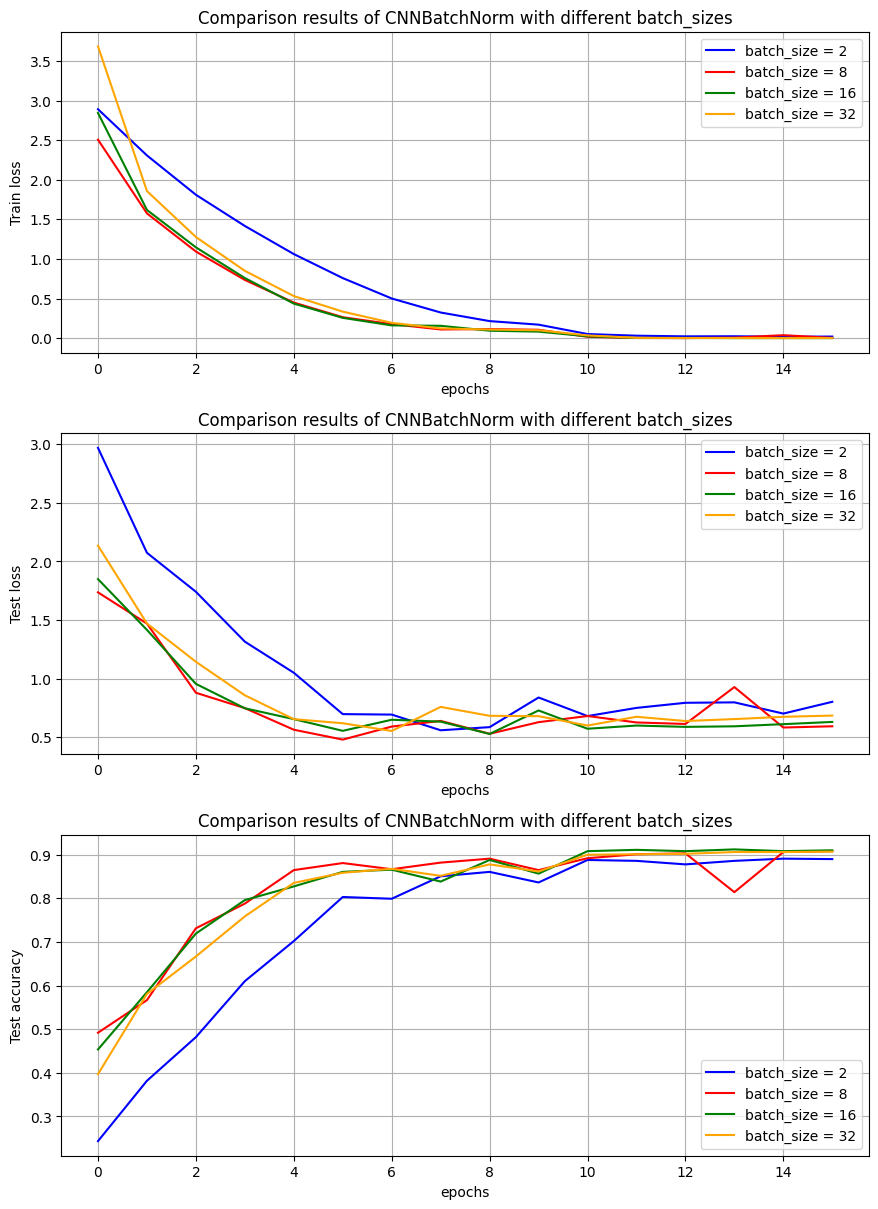

In [85]:
fig, axes = plt.subplots(3, 1, figsize=(9, 12)) 


axes[0].plot(TRAIN_LOSS_BN[2], label=f"batch_size = {batch_sizes[0]}", color='blue')
axes[0].plot(TRAIN_LOSS_BN[8], label=f"batch_size = {batch_sizes[1]}", color='red')
axes[0].plot(TRAIN_LOSS_BN[16], label=f"batch_size = {batch_sizes[2]}", color='green')
axes[0].plot(TRAIN_LOSS_BN[32], label=f"batch_size = {batch_sizes[3]}", color='orange') 
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('Train loss')
axes[0].set_title('Comparison results of CNNBatchNorm with different batch_sizes') 
axes[0].legend() 
axes[0].grid(True)
plt.tight_layout()

axes[1].plot(TEST_LOSS_BN[2], label=f"batch_size = {batch_sizes[0]}", color='blue')
axes[1].plot(TEST_LOSS_BN[8], label=f"batch_size = {batch_sizes[1]}", color='red')
axes[1].plot(TEST_LOSS_BN[16], label=f"batch_size = {batch_sizes[2]}", color='green')
axes[1].plot(TEST_LOSS_BN[32], label=f"batch_size = {batch_sizes[3]}", color='orange')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('Test loss')
axes[1].set_title('Comparison results of CNNBatchNorm with different batch_sizes')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()

axes[2].plot(TEST_ACC_BN[2], label=f"batch_size = {batch_sizes[0]}", color='blue')
axes[2].plot(TEST_ACC_BN[8], label=f"batch_size = {batch_sizes[1]}", color='red')
axes[2].plot(TEST_ACC_BN[16], label=f"batch_size = {batch_sizes[2]}", color='green')
axes[2].plot(TEST_ACC_BN[32], label=f"batch_size = {batch_sizes[3]}", color='orange')
axes[2].set_xlabel('epochs')
axes[2].set_ylabel('Test accuracy')
axes[2].set_title('Comparison results of CNNBatchNorm with different batch_sizes')
axes[2].legend()
axes[2].grid(True)

plt.show()

In [81]:
class CNNGroupNorm(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1), 
                                    nn.GroupNorm(num_groups=8, num_channels=16), nn.ReLU(),
                                    nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=1),
                                    nn.GroupNorm(num_groups=8, num_channels=16), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=1),
                                    nn.GroupNorm(num_groups=8, num_channels=32), nn.ReLU(),
                                    nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1),
                                    nn.GroupNorm(num_groups=8, num_channels=32), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
                                    nn.GroupNorm(num_groups=8, num_channels=64), nn.ReLU(),
                                    nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
                                    nn.GroupNorm(num_groups=8, num_channels=64), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fclayer = nn.Sequential(nn.Flatten(), nn.Linear(16 * 16 * 64, 4096), nn.ReLU(), 
                                     nn.Linear(4096, num_classes))
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fclayer(x)
        return x


In [83]:
batch_sizes = [2, 8, 16, 32]

TRAIN_LOSS_GN = {}
TEST_LOSS_GN = {}
TRAIN_ACC_GN = {}
TEST_ACC_GN = {}

for b_size in batch_sizes:
    
    train_loader = DataLoader(balanced_train, batch_size=b_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=b_size, shuffle=False)

    log_dir = 'runs/simpsons_experiment_cnngn'+str(b_size)
    writer = SummaryWriter(log_dir=log_dir)
    
    model_cnngn = CNNGroupNorm().to(device)
    optimizer = torch.optim.AdamW(model_cnngn.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss().to(device)
    
    tr_l, t_l, tr_acc, t_acc = train_model(model_cnngn, device, train_loader, test_loader, 16, optimizer, criterion, writer)
    
    TRAIN_LOSS_GN[b_size] = tr_l
    TRAIN_ACC_GN[b_size] = tr_acc
    TEST_LOSS_GN[b_size] = t_l
    TEST_ACC_GN[b_size] = t_acc

    print(f"Batch size: {b_size}")
    print(evaluate(model_cnngn, device, test_loader))
    
    file_name = 'simpsons_cnngn'+str(b_size)+'.pth'
    torch.save(model_cnngn.state_dict(), file_name)

cuda


  6%|▋         | 1/16 [02:00<30:14, 120.99s/it]

Epoch [2/16] Train Loss: 2.0915, Acc: 0.37 | Test Loss: 1.5536, Acc: 0.55


 19%|█▉        | 3/16 [06:02<26:09, 120.75s/it]

Epoch [4/16] Train Loss: 0.6880, Acc: 0.78 | Test Loss: 0.7575, Acc: 0.79


 31%|███▏      | 5/16 [10:05<22:13, 121.20s/it]

Epoch [6/16] Train Loss: 0.1586, Acc: 0.94 | Test Loss: 0.9781, Acc: 0.83


 44%|████▍     | 7/16 [14:07<18:10, 121.17s/it]

Epoch [8/16] Train Loss: 0.0945, Acc: 0.96 | Test Loss: 1.0207, Acc: 0.84


 56%|█████▋    | 9/16 [18:11<14:11, 121.71s/it]

Epoch [10/16] Train Loss: 0.0708, Acc: 0.97 | Test Loss: 1.0498, Acc: 0.83


 69%|██████▉   | 11/16 [22:20<10:16, 123.29s/it]

Epoch [12/16] Train Loss: 0.0081, Acc: 0.99 | Test Loss: 1.0715, Acc: 0.85


 81%|████████▏ | 13/16 [26:30<06:11, 123.79s/it]

Epoch [14/16] Train Loss: 0.0052, Acc: 0.99 | Test Loss: 1.2687, Acc: 0.85


 94%|█████████▍| 15/16 [30:34<02:03, 123.09s/it]

Epoch [16/16] Train Loss: 0.0065, Acc: 0.99 | Test Loss: 1.0563, Acc: 0.85


100%|██████████| 16/16 [32:36<00:00, 122.27s/it]


Обучение заняло: 1956.26 секунд или: 32.60 минут
Batch size: 2
Accuracy на тестовых данных: 0.85
cuda


  6%|▋         | 1/16 [01:03<15:55, 63.71s/it]

Epoch [2/16] Train Loss: 1.9782, Acc: 0.40 | Test Loss: 1.4801, Acc: 0.58


 19%|█▉        | 3/16 [03:11<13:49, 63.78s/it]

Epoch [4/16] Train Loss: 0.6793, Acc: 0.79 | Test Loss: 0.6077, Acc: 0.84


 31%|███▏      | 5/16 [05:19<11:43, 63.99s/it]

Epoch [6/16] Train Loss: 0.1577, Acc: 0.94 | Test Loss: 0.6105, Acc: 0.85


 44%|████▍     | 7/16 [07:26<09:31, 63.50s/it]

Epoch [8/16] Train Loss: 0.0730, Acc: 0.97 | Test Loss: 0.6629, Acc: 0.87


 56%|█████▋    | 9/16 [09:39<07:35, 65.14s/it]

Epoch [10/16] Train Loss: 0.0668, Acc: 0.97 | Test Loss: 0.6378, Acc: 0.87


 69%|██████▉   | 11/16 [11:45<05:19, 63.89s/it]

Epoch [12/16] Train Loss: 0.0025, Acc: 0.99 | Test Loss: 0.6032, Acc: 0.89


 81%|████████▏ | 13/16 [13:49<03:09, 63.10s/it]

Epoch [14/16] Train Loss: 0.0066, Acc: 0.99 | Test Loss: 0.6508, Acc: 0.89


 94%|█████████▍| 15/16 [15:55<01:02, 62.94s/it]

Epoch [16/16] Train Loss: 0.0063, Acc: 0.99 | Test Loss: 0.7454, Acc: 0.89


100%|██████████| 16/16 [16:58<00:00, 63.68s/it]


Обучение заняло: 1018.81 секунд или: 16.98 минут
Batch size: 8
Accuracy на тестовых данных: 0.89
cuda


  6%|▋         | 1/16 [00:52<13:05, 52.37s/it]

Epoch [2/16] Train Loss: 2.2354, Acc: 0.32 | Test Loss: 1.9365, Acc: 0.44


 19%|█▉        | 3/16 [02:38<11:29, 53.06s/it]

Epoch [4/16] Train Loss: 1.0506, Acc: 0.68 | Test Loss: 0.9348, Acc: 0.74


 31%|███▏      | 5/16 [04:25<09:45, 53.25s/it]

Epoch [6/16] Train Loss: 0.3594, Acc: 0.88 | Test Loss: 0.5635, Acc: 0.84


 44%|████▍     | 7/16 [06:11<07:58, 53.14s/it]

Epoch [8/16] Train Loss: 0.1178, Acc: 0.95 | Test Loss: 0.6220, Acc: 0.88


 56%|█████▋    | 9/16 [07:58<06:13, 53.35s/it]

Epoch [10/16] Train Loss: 0.0628, Acc: 0.97 | Test Loss: 0.7537, Acc: 0.87


 69%|██████▉   | 11/16 [09:44<04:25, 53.06s/it]

Epoch [12/16] Train Loss: 0.0016, Acc: 0.99 | Test Loss: 0.7004, Acc: 0.90


 81%|████████▏ | 13/16 [11:30<02:39, 53.01s/it]

Epoch [14/16] Train Loss: 0.0012, Acc: 0.99 | Test Loss: 0.7037, Acc: 0.90


 94%|█████████▍| 15/16 [13:17<00:53, 53.18s/it]

Epoch [16/16] Train Loss: 0.0018, Acc: 0.99 | Test Loss: 0.6802, Acc: 0.90


100%|██████████| 16/16 [14:10<00:00, 53.15s/it]


Обучение заняло: 850.48 секунд или: 14.17 минут
Batch size: 16
Accuracy на тестовых данных: 0.90
cuda


  6%|▋         | 1/16 [00:48<12:09, 48.67s/it]

Epoch [2/16] Train Loss: 1.8956, Acc: 0.43 | Test Loss: 1.5819, Acc: 0.54


 19%|█▉        | 3/16 [02:26<10:33, 48.72s/it]

Epoch [4/16] Train Loss: 0.9888, Acc: 0.70 | Test Loss: 0.8754, Acc: 0.75


 31%|███▏      | 5/16 [04:05<09:03, 49.44s/it]

Epoch [6/16] Train Loss: 0.2892, Acc: 0.90 | Test Loss: 0.7148, Acc: 0.83


 44%|████▍     | 7/16 [05:44<07:24, 49.39s/it]

Epoch [8/16] Train Loss: 0.0816, Acc: 0.96 | Test Loss: 0.8318, Acc: 0.86


 56%|█████▋    | 9/16 [07:24<05:48, 49.79s/it]

Epoch [10/16] Train Loss: 0.0895, Acc: 0.96 | Test Loss: 0.9292, Acc: 0.85


 69%|██████▉   | 11/16 [09:05<04:10, 50.04s/it]

Epoch [12/16] Train Loss: 0.0023, Acc: 0.99 | Test Loss: 0.8416, Acc: 0.88


 81%|████████▏ | 13/16 [10:44<02:30, 50.00s/it]

Epoch [14/16] Train Loss: 0.0017, Acc: 0.99 | Test Loss: 0.8528, Acc: 0.88


 94%|█████████▍| 15/16 [12:26<00:50, 50.59s/it]

Epoch [16/16] Train Loss: 0.0006, Acc: 0.99 | Test Loss: 0.8635, Acc: 0.88


100%|██████████| 16/16 [13:18<00:00, 49.89s/it]


Обучение заняло: 798.29 секунд или: 13.30 минут
Batch size: 32
Accuracy на тестовых данных: 0.88


Лучшая accuracy = 0.9 при batch_size = 16.

/tmp/ipykernel_37/933010242.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


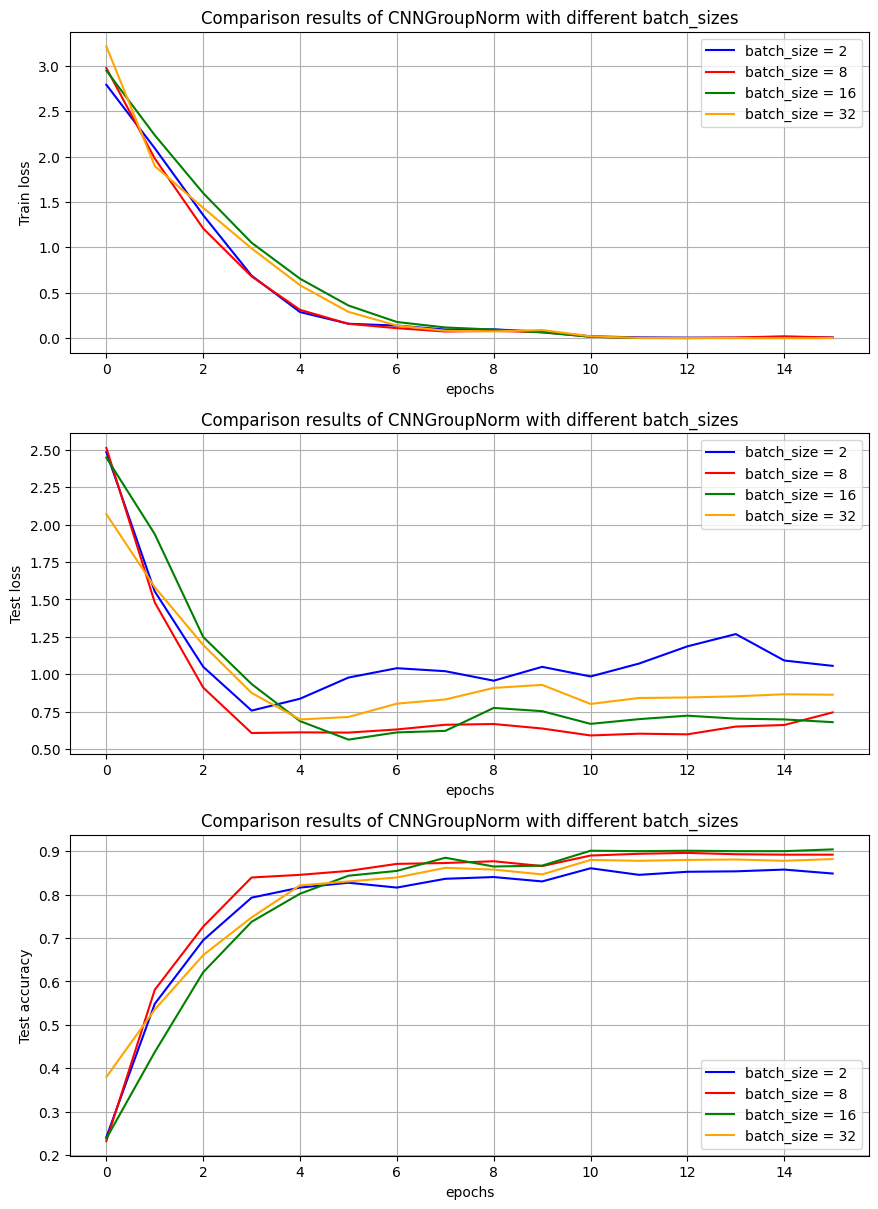

In [84]:
fig, axes = plt.subplots(3, 1, figsize=(9, 12)) 


axes[0].plot(TRAIN_LOSS_GN[2], label=f"batch_size = {batch_sizes[0]}", color='blue')
axes[0].plot(TRAIN_LOSS_GN[8], label=f"batch_size = {batch_sizes[1]}", color='red')
axes[0].plot(TRAIN_LOSS_GN[16], label=f"batch_size = {batch_sizes[2]}", color='green')
axes[0].plot(TRAIN_LOSS_GN[32], label=f"batch_size = {batch_sizes[3]}", color='orange')  
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('Train loss')
axes[0].set_title('Comparison results of CNNGroupNorm with different batch_sizes') 
axes[0].legend() 
axes[0].grid(True)
plt.tight_layout()

axes[1].plot(TEST_LOSS_GN[2], label=f"batch_size = {batch_sizes[0]}", color='blue')
axes[1].plot(TEST_LOSS_GN[8], label=f"batch_size = {batch_sizes[1]}", color='red')
axes[1].plot(TEST_LOSS_GN[16], label=f"batch_size = {batch_sizes[2]}", color='green')
axes[1].plot(TEST_LOSS_GN[32], label=f"batch_size = {batch_sizes[3]}", color='orange')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('Test loss')
axes[1].set_title('Comparison results of CNNGroupNorm with different batch_sizes')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()

axes[2].plot(TEST_ACC_GN[2], label=f"batch_size = {batch_sizes[0]}", color='blue')
axes[2].plot(TEST_ACC_GN[8], label=f"batch_size = {batch_sizes[1]}", color='red')
axes[2].plot(TEST_ACC_GN[16], label=f"batch_size = {batch_sizes[2]}", color='green')
axes[2].plot(TEST_ACC_GN[32], label=f"batch_size = {batch_sizes[3]}", color='orange')
axes[2].set_xlabel('epochs')
axes[2].set_ylabel('Test accuracy')
axes[2].set_title('Comparison results of CNNGroupNorm with different batch_sizes')
axes[2].legend()
axes[2].grid(True)

plt.show()

 Модель с BatchNorm работает лучше чем модель с GroupNorm, возможно потому что GroupNorm более универсален и устойчив к изменениям в данных, а  BatchNorm более эффективен, когда данные однородны (как раз наш случай датасета с Симпсонами. Все картинки в более менее одной цветовой гамме, одного стиля рисовки).

**2.5  Используйте cosine decay with warmup LR scheduling и обучите с ним лучшую модель.**

Будем обучать лучшую модель - CNNBatchNorm.

In [97]:
from torch.optim.lr_scheduler import LambdaLR  
import math

def cosine_decay_with_warmup(optimizer, total_steps, warmup_steps=0):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        else:
            progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            return 0.5 * (1.0 + math.cos(math.pi * progress))
    return LambdaLR(optimizer, lr_lambda)

In [99]:
def train_model_25(model, device, scheduler, train_loader, test_loader, epochs, optimizer, criterion, writer):
    start_time = time.time()
    print(device)
    model.train()
    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
    EPOCHS = epochs
    y_true = []
    y_pred = []
    for epoch in tqdm(range(EPOCHS)):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.cuda())
            pred = output.argmax(dim=1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            y_pred.extend(pred.detach().cpu().numpy())
            y_true.extend(target.cpu().numpy())
            
        scheduler.step()
        
        train_acc.append(accuracy_score(y_true, y_pred))
        train_losses.append(running_loss / len(train_loader))

        
        model.eval()
        loss = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                loss += criterion(output, target).item()
                y_true.extend(target.cpu().numpy())
                y_pred.extend(pred.detach().cpu().numpy())

        
        test_losses.append(loss / len(test_loader))
        test_acc.append(accuracy_score(y_true, y_pred))
        if (epoch+1)%2==0 or epoch+1==EPOCHS:
            print(f'Epoch [{epoch+1}/{epochs}] '
                f'Train Loss: {train_losses[-1]:.4f}, Acc: {train_acc[-1]:.2f} | '
                f'Test Loss: {test_losses[-1]:.4f}, Acc: {test_acc[-1]:.2f}')
            
        writer.add_scalar('Loss/train',train_losses[-1] , epoch)
        writer.add_scalar('Loss/test', test_losses[-1], epoch)
        writer.add_scalar('Accuracy/train', train_acc[-1], epoch)
        writer.add_scalar('Accuracy/test', test_acc[-1], epoch)

        for name, param in model.named_parameters():
            writer.add_histogram(f"params/{name}", param.detach().cpu().numpy(), epoch)
            
    end_time = time.time()
    result_time = end_time - start_time
    print(f"Обучение заняло: {result_time:.2f} секунд или: {result_time / 60:.2f} минут")

    writer.close()
    
    return train_losses, test_losses, train_acc, test_acc

In [89]:
batch_size = 32
train_loader = DataLoader(balanced_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False) 

In [100]:
steps = 16 * len(train_loader)
warmup_steps = int(0.1 * steps)

writer = SummaryWriter(log_dir='runs/simpsons_experiment_cnnbn_decay')

model_cnnbn_decay = CNNBatchNorm().to(device)
scheduler = cosine_decay_with_warmup(optimizer, steps, warmup_steps)
optimizer = torch.optim.AdamW(model_cnnbn_decay.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
tr_l_cnnbn_decay, t_l_cnnbn_decay, tr_acc_cnnbn_decay, t_acc_cnnbn_decay = train_model_25(model_cnnbn_decay, device, scheduler,
                                                                            train_loader, test_loader, 16, optimizer, criterion, writer)
file_name = 'simpsons_cnnbn_decay.pth'
torch.save(model_cnnbn_decay.state_dict(), file_name)


cuda


  6%|▋         | 1/16 [00:49<12:23, 49.59s/it]

Epoch [2/16] Train Loss: 1.8517, Acc: 0.43 | Test Loss: 1.6830, Acc: 0.52


 19%|█▉        | 3/16 [02:31<11:01, 50.92s/it]

Epoch [4/16] Train Loss: 0.9337, Acc: 0.72 | Test Loss: 0.9251, Acc: 0.74


 31%|███▏      | 5/16 [04:13<09:18, 50.76s/it]

Epoch [6/16] Train Loss: 0.3496, Acc: 0.88 | Test Loss: 0.7576, Acc: 0.83


 44%|████▍     | 7/16 [05:55<07:38, 50.93s/it]

Epoch [8/16] Train Loss: 0.1723, Acc: 0.94 | Test Loss: 0.7142, Acc: 0.85


 56%|█████▋    | 9/16 [07:37<05:57, 51.07s/it]

Epoch [10/16] Train Loss: 0.1056, Acc: 0.96 | Test Loss: 0.7673, Acc: 0.86


 69%|██████▉   | 11/16 [09:21<04:16, 51.30s/it]

Epoch [12/16] Train Loss: 0.0768, Acc: 0.97 | Test Loss: 0.8049, Acc: 0.88


 81%|████████▏ | 13/16 [11:01<02:32, 50.78s/it]

Epoch [14/16] Train Loss: 0.0680, Acc: 0.97 | Test Loss: 0.7975, Acc: 0.86


 94%|█████████▍| 15/16 [12:46<00:51, 51.68s/it]

Epoch [16/16] Train Loss: 0.0656, Acc: 0.97 | Test Loss: 0.8004, Acc: 0.87


100%|██████████| 16/16 [13:37<00:00, 51.12s/it]


Обучение заняло: 817.85 секунд или: 13.63 минут


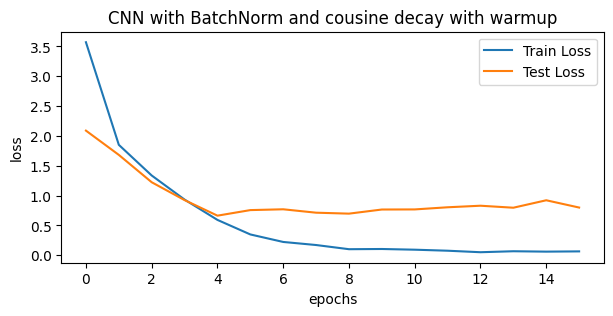

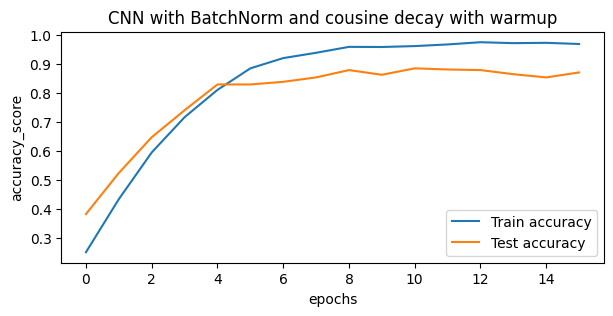

'Accuracy на тестовых данных: 0.87'

In [104]:
plot_charts('CNN with BatchNorm and cousine decay with warmup', tr_l_cnnbn_decay, t_l_cnnbn_decay, tr_acc_cnnbn_decay, t_acc_cnnbn_decay)
evaluate(model_cnnbn_decay, device, test_loader)

Accuracy снизилась, было 0.91 при другом scheduler.

**2.6  Имплементируйте residual block, добавьте его в вашу модель и проведите хотя бы один эксперимент.**

In [101]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        identity = x

        out = self.relu(self.conv1(x))
        out = self.conv2(out)

        if isinstance(self.shortcut, nn.Conv2d) or len(list(self.shortcut.modules())) > 1:
            identity = self.shortcut(identity)
        
        out += identity
        out = self.relu(out)
        return out

In [102]:
class CNNResidual(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        
        self.layer1 = nn.Sequential(ResidualBlock(3, 16, stride=1),ResidualBlock(16, 16, stride=1),
                                    nn.MaxPool2d(2))

        self.layer2 = nn.Sequential(ResidualBlock(16, 32, stride=1), ResidualBlock(32, 32, stride=1),
                                    nn.MaxPool2d(2))

        self.layer3 = nn.Sequential(ResidualBlock(32, 64, stride=1),ResidualBlock(64, 64, stride=1),
                                    nn.MaxPool2d(2))
        
        self.fclayer = nn.Sequential(nn.Flatten(), nn.Linear(16 * 16 * 64, 4096),
                                     nn.ReLU(), nn.Linear(4096, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fclayer(x)
        return x

In [103]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_cnn_residual')
model_cnnres = CNNResidual().to(device)
optimizer = torch.optim.AdamW(model_cnnres.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
tr_l_res, t_l_res, tr_acc_res, t_acc_res = train_model(model_cnnres, device, train_loader, test_loader, 16, optimizer, criterion, writer)
file_name = 'simpsons_cnn_residual.pth'
torch.save(model_cnnres.state_dict(), file_name)

cuda


  6%|▋         | 1/16 [01:07<16:52, 67.51s/it]

Epoch [2/16] Train Loss: 1.5133, Acc: 0.54 | Test Loss: 1.1651, Acc: 0.66


 19%|█▉        | 3/16 [02:57<12:31, 57.84s/it]

Epoch [4/16] Train Loss: 0.2451, Acc: 0.91 | Test Loss: 0.5739, Acc: 0.87


 31%|███▏      | 5/16 [04:47<10:18, 56.25s/it]

Epoch [6/16] Train Loss: 0.0460, Acc: 0.98 | Test Loss: 0.7345, Acc: 0.87


 44%|████▍     | 7/16 [06:39<08:24, 56.07s/it]

Epoch [8/16] Train Loss: 0.0552, Acc: 0.97 | Test Loss: 0.6540, Acc: 0.87


 56%|█████▋    | 9/16 [08:30<06:29, 55.68s/it]

Epoch [10/16] Train Loss: 0.0256, Acc: 0.98 | Test Loss: 0.7075, Acc: 0.89


 69%|██████▉   | 11/16 [10:21<04:37, 55.53s/it]

Epoch [12/16] Train Loss: 0.0002, Acc: 0.99 | Test Loss: 0.7191, Acc: 0.89


 81%|████████▏ | 13/16 [12:10<02:45, 55.09s/it]

Epoch [14/16] Train Loss: 0.0001, Acc: 0.99 | Test Loss: 0.7442, Acc: 0.89


 94%|█████████▍| 15/16 [14:00<00:55, 55.09s/it]

Epoch [16/16] Train Loss: 0.0000, Acc: 0.99 | Test Loss: 0.7648, Acc: 0.89


100%|██████████| 16/16 [14:55<00:00, 55.99s/it]


Обучение заняло: 895.91 секунд или: 14.93 минут


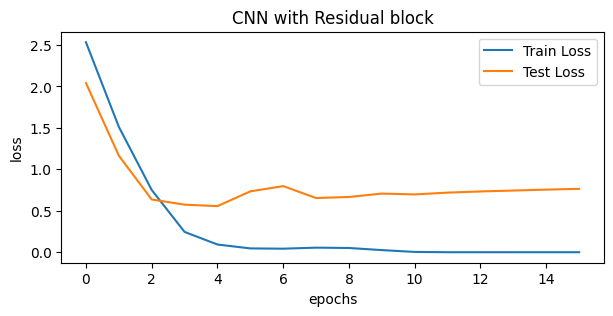

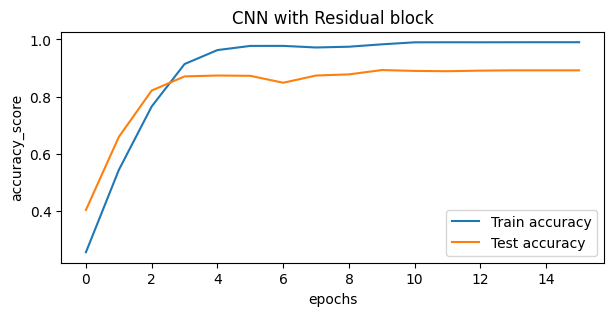

'Accuracy на тестовых данных: 0.89'

In [106]:
plot_charts('CNN with Residual block', tr_l_res, t_l_res, tr_acc_res, t_acc_res)
evaluate(model_cnnres, device, test_loader)

**2.7  Имплементируйте inception block, добавьте его в вашу модель и проведите хотя бы один эксперимент.**

In [116]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_1x1, out_3x3_reduce, out_3x3, out_5x5_reduce, out_5x5, out_pool_proj):
        super(InceptionBlock, self).__init__()
        
        self.branch1 = nn.Sequential(nn.Conv2d(in_channels, out_1x1, kernel_size=1), nn.ReLU())
        
        self.branch2 = nn.Sequential(nn.Conv2d(in_channels, out_3x3_reduce, kernel_size=1), nn.ReLU(),
                                     nn.Conv2d(out_3x3_reduce, out_3x3, kernel_size=3, padding=1), nn.ReLU())
        
        self.branch3 = nn.Sequential(nn.Conv2d(in_channels, out_5x5_reduce, kernel_size=1), nn.ReLU(),
                                     nn.Conv2d(out_5x5_reduce, out_5x5, kernel_size=5, padding=2), nn.ReLU())
        
        self.branch4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                                     nn.Conv2d(in_channels, out_pool_proj, kernel_size=1), nn.ReLU())

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = torch.cat([branch1, branch2, branch3, branch4], dim=1)
        return outputs

In [117]:
class CNNInception(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                    nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.inception1 = InceptionBlock(in_channels=16, out_1x1=8, out_3x3_reduce=8, out_3x3=16, 
                                        out_5x5_reduce=4, out_5x5=8, out_pool_proj=8)
        
        self.layer2 = nn.Sequential(nn.Conv2d(40, 32, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                    nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                    nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1), nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fclayer = nn.Sequential(nn.Flatten(), nn.Linear(64 * 16 * 16, 4096), nn.ReLU(), 
                                     nn.Linear(4096, num_classes))
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.inception1(x) 
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fclayer(x)
        return x

In [119]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_cnn_inception')
model_cnnincep = CNNInception().to(device)
optimizer = torch.optim.AdamW(model_cnnincep.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
tr_l_incep, t_l_incep, tr_acc_incep, t_acc_incep = train_model(model_cnnincep, device, 
                                                               train_loader, test_loader, 12, 
                                                               optimizer, criterion, writer)
file_name = 'simpsons_cnn_inception.pth'
torch.save(model_cnnincep.state_dict(), file_name)

cuda


  8%|▊         | 1/12 [00:51<09:23, 51.19s/it]

Epoch [2/12] Train Loss: 2.7314, Acc: 0.15 | Test Loss: 2.3985, Acc: 0.25


 25%|██▌       | 3/12 [02:33<07:39, 51.03s/it]

Epoch [4/12] Train Loss: 1.4740, Acc: 0.56 | Test Loss: 1.2182, Acc: 0.66


 42%|████▏     | 5/12 [04:14<05:56, 50.86s/it]

Epoch [6/12] Train Loss: 0.2046, Acc: 0.93 | Test Loss: 1.0155, Acc: 0.84


 58%|█████▊    | 7/12 [05:56<04:13, 50.78s/it]

Epoch [8/12] Train Loss: 0.0579, Acc: 0.97 | Test Loss: 1.2185, Acc: 0.84


 75%|███████▌  | 9/12 [07:37<02:32, 50.82s/it]

Epoch [10/12] Train Loss: 0.0505, Acc: 0.98 | Test Loss: 1.2138, Acc: 0.85


 92%|█████████▏| 11/12 [09:20<00:51, 51.00s/it]

Epoch [12/12] Train Loss: 0.0020, Acc: 0.99 | Test Loss: 1.2659, Acc: 0.85


100%|██████████| 12/12 [10:11<00:00, 50.97s/it]


Обучение заняло: 611.70 секунд или: 10.19 минут


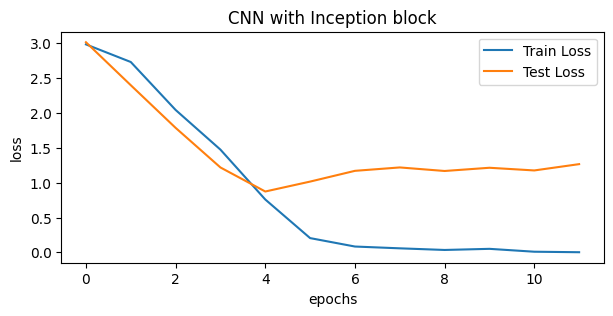

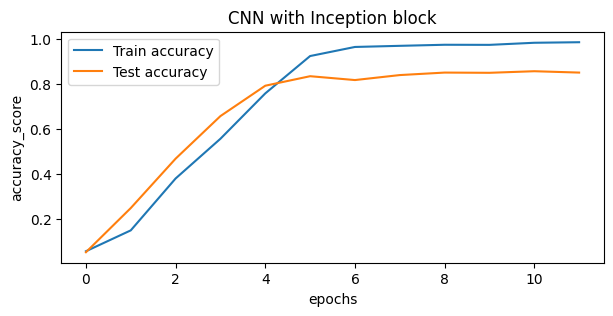

'Accuracy на тестовых данных: 0.85'

In [120]:
plot_charts('CNN with Inception block', tr_l_incep, t_l_incep, tr_acc_incep, t_acc_incep)
evaluate(model_cnnincep, device, test_loader)

**2.8  Модифицируйте вашу модель и постарайтесь улучшить качество классификации. Для этого экспериментируйте с архитектурой модели, гиперпараметрами тренировки и регуляризацией, аугментацией данных (не обязательно прибегать ко всем из предложенных вариантов улучшения).**

In [16]:
class AugmentedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x) 
        return x, y

    def __len__(self):
        return len(self.subset)

In [17]:
import torchvision.transforms.v2 as transforms_v2

train_transform = transforms_v2.Compose([
    transforms_v2.Resize((128, 128)),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.RandomRotation(degrees=10),
    transforms_v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms_v2.ToDtype(torch.float32, scale=True),
    transforms_v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_train = AugmentedSubset(balanced_train, transform=train_transform)

In [18]:
batch_size = 32
train_loader = DataLoader(augmented_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False) 

Будем обучать лучшую модель CNNBatchNorm 

In [20]:
from sklearn.metrics import accuracy_score
writer = SummaryWriter(log_dir='runs/simpsons_experiment_cnnaug')
    
model_cnnaug = CNNBatchNorm().to(device)
optimizer = torch.optim.AdamW(model_cnnaug.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
tr_l_aug, t_l_aug, tr_acc_aug, t_acc_aug = train_model(model_cnnaug, device, train_loader, test_loader, 25, optimizer, criterion, writer)
file_name = 'simpsons_cnnaug.pth'
torch.save(model_cnnaug.state_dict(), file_name)

cuda


  4%|▍         | 1/25 [01:21<32:29, 81.24s/it]

Epoch [2/25] Train Loss: 2.1912, Acc: 0.34 | Test Loss: 2.4042, Acc: 0.29


 12%|█▏        | 3/25 [04:01<29:30, 80.47s/it]

Epoch [4/25] Train Loss: 1.6073, Acc: 0.50 | Test Loss: 2.3723, Acc: 0.34


 20%|██        | 5/25 [06:42<26:45, 80.29s/it]

Epoch [6/25] Train Loss: 1.2354, Acc: 0.61 | Test Loss: 2.3404, Acc: 0.39


 28%|██▊       | 7/25 [09:14<23:21, 77.85s/it]

Epoch [8/25] Train Loss: 0.9077, Acc: 0.71 | Test Loss: 2.0136, Acc: 0.46


 36%|███▌      | 9/25 [11:43<20:15, 75.99s/it]

Epoch [10/25] Train Loss: 0.6768, Acc: 0.77 | Test Loss: 2.2246, Acc: 0.42


 44%|████▍     | 11/25 [14:10<17:28, 74.89s/it]

Epoch [12/25] Train Loss: 0.3912, Acc: 0.85 | Test Loss: 2.2612, Acc: 0.46


 52%|█████▏    | 13/25 [16:39<14:55, 74.62s/it]

Epoch [14/25] Train Loss: 0.2908, Acc: 0.88 | Test Loss: 2.0112, Acc: 0.53


 60%|██████    | 15/25 [19:08<12:25, 74.50s/it]

Epoch [16/25] Train Loss: 0.2188, Acc: 0.89 | Test Loss: 2.0142, Acc: 0.53


 68%|██████▊   | 17/25 [21:38<09:57, 74.74s/it]

Epoch [18/25] Train Loss: 0.1720, Acc: 0.91 | Test Loss: 2.4229, Acc: 0.52


 76%|███████▌  | 19/25 [24:07<07:28, 74.69s/it]

Epoch [20/25] Train Loss: 0.1291, Acc: 0.92 | Test Loss: 2.1970, Acc: 0.56


 84%|████████▍ | 21/25 [26:36<04:58, 74.63s/it]

Epoch [22/25] Train Loss: 0.0773, Acc: 0.94 | Test Loss: 2.7622, Acc: 0.52


 92%|█████████▏| 23/25 [29:03<02:27, 73.89s/it]

Epoch [24/25] Train Loss: 0.0531, Acc: 0.94 | Test Loss: 2.4304, Acc: 0.55


 96%|█████████▌| 24/25 [30:16<01:13, 73.62s/it]

Epoch [25/25] Train Loss: 0.0535, Acc: 0.94 | Test Loss: 2.8674, Acc: 0.49


100%|██████████| 25/25 [31:28<00:00, 75.52s/it]


Обучение заняло: 1888.09 секунд или: 31.47 минут


С аугментацией стало только хуже.

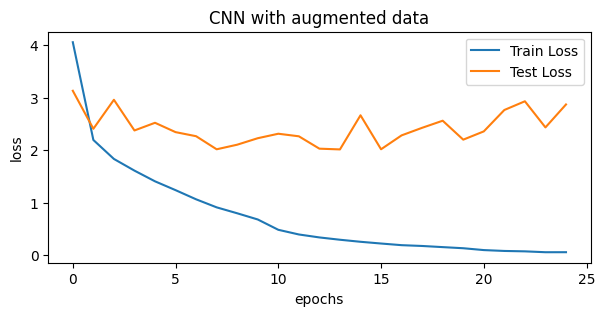

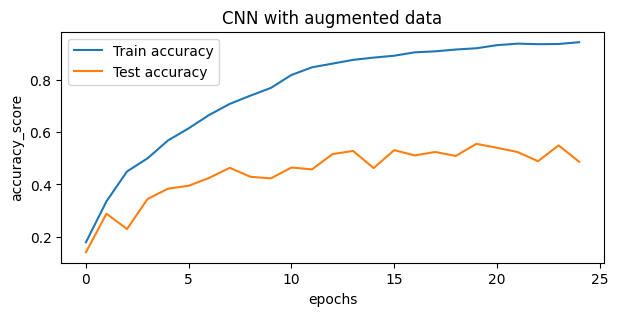

'Accuracy на тестовых данных: 0.49'

In [21]:
plot_charts('CNN with augmented data', tr_l_aug, t_l_aug, tr_acc_aug, t_acc_aug) 
evaluate(model_cnnaug, device, test_loader)  

# Часть 3 (2 балла)
**3.1 Как минимум для двух обученных классификационных архитектур из torchvision.models выполните transfer learning:** 

**3.1.1  Frozen backbone + новый классификатор (FC).**


 **AlexNet**

In [40]:
!pip install ptflops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [41]:
import torchvision.models as models
from ptflops import get_model_complexity_info

model_AN = models.alexnet(pretrained=True) 

input_shape = (3, 128, 128) 
flops, params = get_model_complexity_info(
    model_AN, input_shape,
    as_strings=False, print_per_layer_stat=False
)

print(f"FLOPs: {(flops / 1e6):.4f} M")
print(f"Parameters: {(params / 1e6):.4f} M")

print(model_AN)


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

FLOPs: 255.5459 M
Parameters: 61.1008 M
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_featur

In [42]:
for param in model_AN.parameters():
    param.requires_grad = False

num_features = 4096
model_AN.classifier[6] = nn.Linear(num_features, 20)

for name, param in model_AN.named_parameters():
    if param.requires_grad:
        print(name)

classifier.6.weight
classifier.6.bias


In [43]:
batch_size = 64
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False) 

In [44]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_an')
model_AN.to(device)
optimizer = torch.optim.AdamW(model_AN.classifier[6].parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
tr_l_an, t_l_an, tr_acc_an, t_acc_an = train_model(model_AN, device, train_loader, test_loader, 20, optimizer, criterion, writer)
file_name = 'simpsons_an.pth'

cuda


  5%|▌         | 1/20 [01:07<21:21, 67.45s/it]

Epoch [2/20] Train Loss: 0.9178, Acc: 0.73 | Test Loss: 0.7046, Acc: 0.80


 15%|█▌        | 3/20 [03:16<18:25, 65.05s/it]

Epoch [4/20] Train Loss: 0.5300, Acc: 0.84 | Test Loss: 0.4096, Acc: 0.89


 25%|██▌       | 5/20 [05:35<16:47, 67.15s/it]

Epoch [6/20] Train Loss: 0.3642, Acc: 0.90 | Test Loss: 0.3459, Acc: 0.90


 35%|███▌      | 7/20 [07:46<14:21, 66.28s/it]

Epoch [8/20] Train Loss: 0.2654, Acc: 0.93 | Test Loss: 0.2428, Acc: 0.94


 45%|████▌     | 9/20 [09:58<12:07, 66.13s/it]

Epoch [10/20] Train Loss: 0.2033, Acc: 0.95 | Test Loss: 0.2468, Acc: 0.93


 55%|█████▌    | 11/20 [12:17<10:10, 67.80s/it]

Epoch [12/20] Train Loss: 0.1211, Acc: 0.98 | Test Loss: 0.1679, Acc: 0.97


 65%|██████▌   | 13/20 [15:24<09:13, 79.09s/it]

Epoch [14/20] Train Loss: 0.1056, Acc: 0.98 | Test Loss: 0.1809, Acc: 0.96


 75%|███████▌  | 15/20 [17:34<05:59, 71.91s/it]

Epoch [16/20] Train Loss: 0.0916, Acc: 0.99 | Test Loss: 0.1553, Acc: 0.98


 85%|████████▌ | 17/20 [19:49<03:27, 69.18s/it]

Epoch [18/20] Train Loss: 0.0806, Acc: 0.99 | Test Loss: 0.1618, Acc: 0.97


 95%|█████████▌| 19/20 [22:00<01:07, 67.29s/it]

Epoch [20/20] Train Loss: 0.0701, Acc: 0.99 | Test Loss: 0.1448, Acc: 0.97


100%|██████████| 20/20 [23:06<00:00, 69.30s/it]

Обучение заняло: 1386.01 секунд или: 23.10 минут


In [45]:
torch.save(model_AN.state_dict(), file_name)

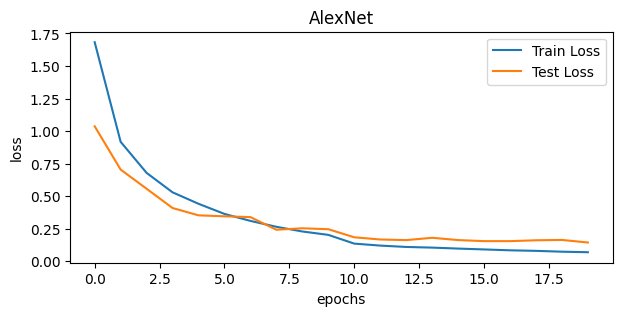

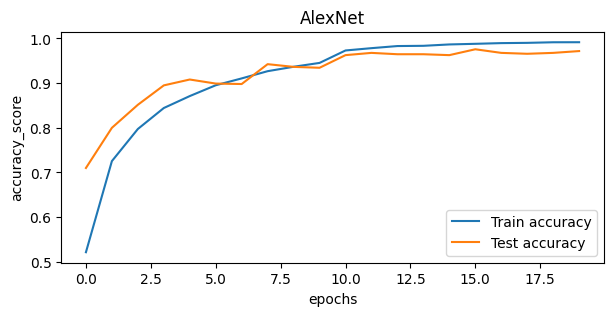

'Accuracy на тестовых данных: 0.97'

In [46]:
plot_charts('AlexNet', tr_l_an, t_l_an, tr_acc_an, t_acc_an)
evaluate(model_AN, device, test_loader)

**ResNet18**

In [47]:
from torchvision.models import resnet18
model_RN = models.resnet18(pretrained=True)

input_shape = (3, 128, 128)
flops, params = get_model_complexity_info(
    model_RN, input_shape,
    as_strings=False, print_per_layer_stat=False
)

print(f"FLOPs: {(flops / 1e6):.4f} M")
print(f"Parameters: {(params / 1e6):.4f} M")

print(model_RN)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FLOPs: 596.3663 M
Parameters: 11.6895 M
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [48]:
for param in model_RN.parameters():
    param.requires_grad = False

num_features = 512
model_RN.fc = nn.Linear(num_features, 20)

for name, param in model_RN.named_parameters():
    if param.requires_grad:
        print(name)

fc.weight
fc.bias


In [49]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_rn')
model_RN.to(device)
optimizer = torch.optim.AdamW(model_RN.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
tr_l_rn, t_l_rn, tr_acc_rn, t_acc_rn = train_model(model_RN, device, train_loader, test_loader, 50, optimizer, criterion, writer)
file_name = 'simpsons_rn.pth'
torch.save(model_RN.state_dict(), file_name)

cuda


  2%|▏         | 1/50 [01:07<55:12, 67.60s/it]

Epoch [2/50] Train Loss: 1.1973, Acc: 0.66 | Test Loss: 1.2181, Acc: 0.66


  6%|▌         | 3/50 [03:47<59:09, 75.52s/it]  

Epoch [4/50] Train Loss: 1.0072, Acc: 0.71 | Test Loss: 1.1323, Acc: 0.70


 10%|█         | 5/50 [06:00<52:39, 70.21s/it]

Epoch [6/50] Train Loss: 0.9333, Acc: 0.73 | Test Loss: 1.0827, Acc: 0.71


 14%|█▍        | 7/50 [08:13<48:51, 68.18s/it]

Epoch [8/50] Train Loss: 0.8906, Acc: 0.74 | Test Loss: 1.0201, Acc: 0.71


 18%|█▊        | 9/50 [10:30<46:39, 68.29s/it]

Epoch [10/50] Train Loss: 0.8618, Acc: 0.74 | Test Loss: 1.0158, Acc: 0.71


 22%|██▏       | 11/50 [12:43<43:51, 67.47s/it]

Epoch [12/50] Train Loss: 0.8152, Acc: 0.76 | Test Loss: 0.9606, Acc: 0.74


 26%|██▌       | 13/50 [14:59<41:40, 67.58s/it]

Epoch [14/50] Train Loss: 0.8031, Acc: 0.76 | Test Loss: 0.9471, Acc: 0.74


 30%|███       | 15/50 [17:19<40:16, 69.06s/it]

Epoch [16/50] Train Loss: 0.7964, Acc: 0.77 | Test Loss: 0.9375, Acc: 0.73


 34%|███▍      | 17/50 [19:35<37:40, 68.51s/it]

Epoch [18/50] Train Loss: 0.7871, Acc: 0.77 | Test Loss: 0.9513, Acc: 0.74


 38%|███▊      | 19/50 [21:54<35:45, 69.22s/it]

Epoch [20/50] Train Loss: 0.7803, Acc: 0.77 | Test Loss: 0.9207, Acc: 0.74


 42%|████▏     | 21/50 [24:13<33:23, 69.08s/it]

Epoch [22/50] Train Loss: 0.7587, Acc: 0.78 | Test Loss: 0.9031, Acc: 0.74


 46%|████▌     | 23/50 [26:34<31:32, 70.10s/it]

Epoch [24/50] Train Loss: 0.7553, Acc: 0.78 | Test Loss: 0.9021, Acc: 0.74


 50%|█████     | 25/50 [29:12<31:04, 74.57s/it]

Epoch [26/50] Train Loss: 0.7514, Acc: 0.78 | Test Loss: 0.9181, Acc: 0.74


 54%|█████▍    | 27/50 [31:46<29:02, 75.75s/it]

Epoch [28/50] Train Loss: 0.7498, Acc: 0.78 | Test Loss: 0.9044, Acc: 0.74


 58%|█████▊    | 29/50 [34:35<28:13, 80.63s/it]

Epoch [30/50] Train Loss: 0.7461, Acc: 0.78 | Test Loss: 0.8972, Acc: 0.74


 62%|██████▏   | 31/50 [36:55<23:48, 75.17s/it]

Epoch [32/50] Train Loss: 0.7348, Acc: 0.78 | Test Loss: 0.9091, Acc: 0.74


 66%|██████▌   | 33/50 [39:10<20:12, 71.35s/it]

Epoch [34/50] Train Loss: 0.7346, Acc: 0.78 | Test Loss: 0.9065, Acc: 0.73


 70%|███████   | 35/50 [41:24<17:14, 68.98s/it]

Epoch [36/50] Train Loss: 0.7332, Acc: 0.78 | Test Loss: 0.9071, Acc: 0.73


 74%|███████▍  | 37/50 [44:13<16:49, 77.64s/it]

Epoch [38/50] Train Loss: 0.7314, Acc: 0.78 | Test Loss: 0.9041, Acc: 0.74


 78%|███████▊  | 39/50 [46:53<14:13, 77.58s/it]

Epoch [40/50] Train Loss: 0.7302, Acc: 0.79 | Test Loss: 0.8966, Acc: 0.74


 82%|████████▏ | 41/50 [49:07<10:49, 72.13s/it]

Epoch [42/50] Train Loss: 0.7255, Acc: 0.79 | Test Loss: 0.9007, Acc: 0.74


 86%|████████▌ | 43/50 [51:24<08:11, 70.24s/it]

Epoch [44/50] Train Loss: 0.7240, Acc: 0.79 | Test Loss: 0.8953, Acc: 0.74


 90%|█████████ | 45/50 [53:38<05:43, 68.67s/it]

Epoch [46/50] Train Loss: 0.7242, Acc: 0.79 | Test Loss: 0.9050, Acc: 0.74


 94%|█████████▍| 47/50 [55:54<03:25, 68.60s/it]

Epoch [48/50] Train Loss: 0.7236, Acc: 0.79 | Test Loss: 0.8949, Acc: 0.74


 98%|█████████▊| 49/50 [58:26<01:12, 72.74s/it]

Epoch [50/50] Train Loss: 0.7226, Acc: 0.79 | Test Loss: 0.8949, Acc: 0.74


100%|██████████| 50/50 [59:33<00:00, 71.48s/it]

Обучение заняло: 3573.89 секунд или: 59.56 минут


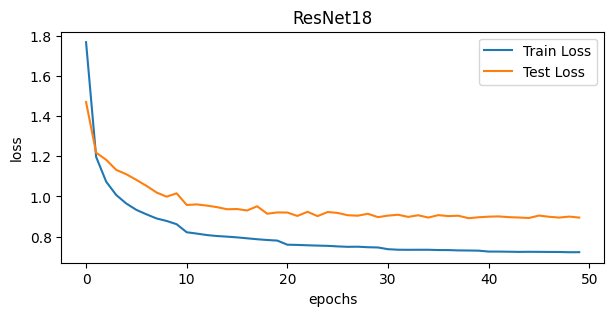

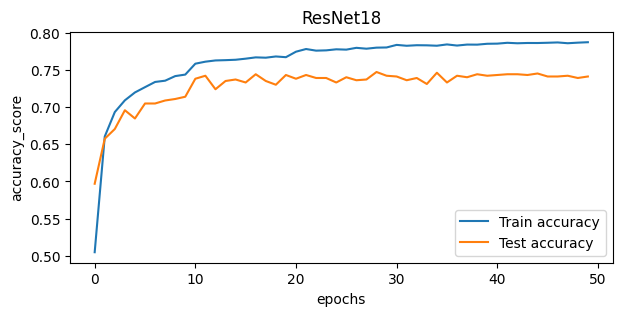

'Accuracy на тестовых данных: 0.74'

In [57]:
plot_charts('ResNet18', tr_l_rn, t_l_rn, tr_acc_rn, t_acc_rn)
evaluate(model_RN, device, test_loader)

**3.1.2  Fine-tune последних N слоёв/всего бэкбона (смотря что позволят ресурсы) + новый классификатор (FC).**

**AlexNet**

In [50]:
import torchvision.models as models

model_AN_new = models.alexnet(pretrained=True) 
        
for param in model_AN_new.parameters():
    param.requires_grad = False
        
model_AN_new.features[-1].requires_grad_(True) 
model_AN_new.features[-3].requires_grad_(True)  


model_AN_new.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(256 * 6 * 6, 4096), nn.ReLU(),
                                 nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(),
                                 nn.Linear(4096, 20))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
model_AN_new.to(device)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model_AN_new.parameters()), lr=0.0001)
criterion = nn.CrossEntropyLoss()

writer = SummaryWriter(log_dir='runs/simpsons_experiment_an_new')

criterion = nn.CrossEntropyLoss().to(device)
tr_l_an_new, t_l_an_new, tr_acc_an_new, t_acc_an_new = train_model(model_AN_new, device, train_loader, test_loader, 16, optimizer, criterion, writer)
file_name = 'simpsons_an_new.pth'
torch.save(model_AN_new.state_dict(), file_name)

cuda


  6%|▋         | 1/16 [01:09<17:15, 69.06s/it]

Epoch [2/16] Train Loss: 0.4632, Acc: 0.87 | Test Loss: 0.2628, Acc: 0.93


 19%|█▉        | 3/16 [03:43<16:18, 75.27s/it]

Epoch [4/16] Train Loss: 0.0368, Acc: 0.99 | Test Loss: 0.0247, Acc: 1.00


 31%|███▏      | 5/16 [06:05<13:17, 72.50s/it]

Epoch [6/16] Train Loss: 0.0069, Acc: 1.00 | Test Loss: 0.0213, Acc: 0.99


 44%|████▍     | 7/16 [08:29<10:51, 72.44s/it]

Epoch [8/16] Train Loss: 0.0035, Acc: 1.00 | Test Loss: 0.0156, Acc: 1.00


 56%|█████▋    | 9/16 [11:17<09:18, 79.76s/it]

Epoch [10/16] Train Loss: 0.0706, Acc: 0.98 | Test Loss: 0.0626, Acc: 0.98


 69%|██████▉   | 11/16 [13:48<06:25, 77.05s/it]

Epoch [12/16] Train Loss: 0.0012, Acc: 1.00 | Test Loss: 0.0115, Acc: 1.00


 81%|████████▏ | 13/16 [16:25<03:54, 78.32s/it]

Epoch [14/16] Train Loss: 0.0008, Acc: 1.00 | Test Loss: 0.0113, Acc: 1.00


 94%|█████████▍| 15/16 [19:19<01:21, 81.89s/it]

Epoch [16/16] Train Loss: 0.0006, Acc: 1.00 | Test Loss: 0.0152, Acc: 1.00


100%|██████████| 16/16 [20:33<00:00, 77.09s/it]


Обучение заняло: 1233.42 секунд или: 20.56 минут


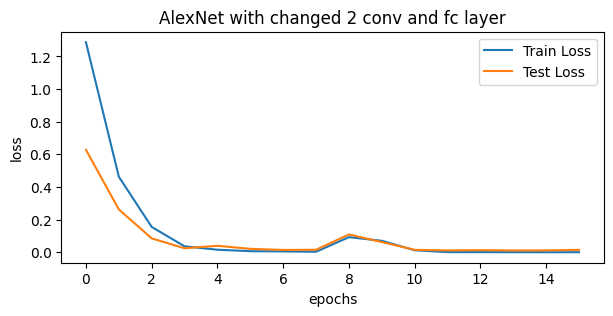

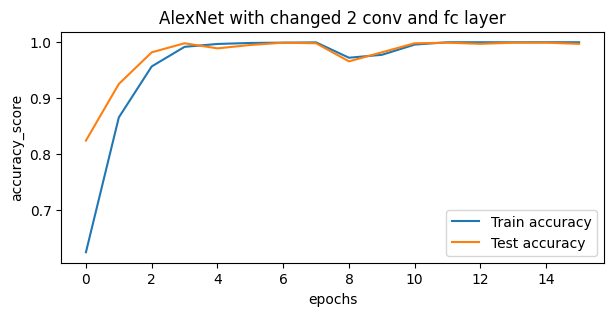

'Accuracy на тестовых данных: 1.00'

In [52]:
plot_charts('AlexNet with changed 2 conv and fc layer', tr_l_an_new, t_l_an_new, tr_acc_an_new,  t_acc_an_new)
evaluate(model_AN_new, device, test_loader)

**Resnet18**

In [53]:
model_RN_new = models.resnet18(pretrained=True)
        
for param in model_RN_new.parameters():
    param.requires_grad = False
        
for param in model_RN_new.layer4.parameters():
        param.requires_grad = True
    
model_RN_new.fc = nn.Linear(model_RN_new.fc.in_features, 20)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
writer = SummaryWriter(log_dir='runs/simpsons_experiment_rn_new')
model_RN_new.to(device)
optimizer = torch.optim.AdamW(model_RN_new.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
tr_l_rn_new, t_l_rn_new, tr_acc_rn_new, t_acc_rn_new = train_model(model_RN_new, device, train_loader, test_loader, 50, optimizer, criterion, writer)
file_name = 'simpsons_rn_new.pth'
torch.save(model_RN_new.state_dict(), file_name)

cuda


  2%|▏         | 1/50 [01:18<1:04:17, 78.72s/it]

Epoch [2/50] Train Loss: 1.1865, Acc: 0.66 | Test Loss: 1.2550, Acc: 0.65


  6%|▌         | 3/50 [03:47<58:46, 75.03s/it]  

Epoch [4/50] Train Loss: 0.9968, Acc: 0.71 | Test Loss: 1.1140, Acc: 0.70


 10%|█         | 5/50 [06:16<55:44, 74.33s/it]

Epoch [6/50] Train Loss: 0.9292, Acc: 0.73 | Test Loss: 1.0344, Acc: 0.72


 14%|█▍        | 7/50 [08:45<53:26, 74.58s/it]

Epoch [8/50] Train Loss: 0.8814, Acc: 0.74 | Test Loss: 1.0152, Acc: 0.72


 18%|█▊        | 9/50 [11:08<50:09, 73.40s/it]

Epoch [10/50] Train Loss: 0.8541, Acc: 0.75 | Test Loss: 0.9848, Acc: 0.72


 22%|██▏       | 11/50 [13:34<47:24, 72.94s/it]

Epoch [12/50] Train Loss: 0.8070, Acc: 0.76 | Test Loss: 0.9765, Acc: 0.72


 26%|██▌       | 13/50 [15:57<44:27, 72.09s/it]

Epoch [14/50] Train Loss: 0.7980, Acc: 0.77 | Test Loss: 0.9634, Acc: 0.72


 30%|███       | 15/50 [18:21<42:05, 72.15s/it]

Epoch [16/50] Train Loss: 0.7882, Acc: 0.77 | Test Loss: 0.9416, Acc: 0.73


 34%|███▍      | 17/50 [20:46<39:41, 72.17s/it]

Epoch [18/50] Train Loss: 0.7806, Acc: 0.77 | Test Loss: 0.9294, Acc: 0.75


 38%|███▊      | 19/50 [23:10<37:18, 72.23s/it]

Epoch [20/50] Train Loss: 0.7753, Acc: 0.77 | Test Loss: 0.9299, Acc: 0.74


 42%|████▏     | 21/50 [25:37<35:09, 72.74s/it]

Epoch [22/50] Train Loss: 0.7518, Acc: 0.78 | Test Loss: 0.9132, Acc: 0.73


 46%|████▌     | 23/50 [28:02<32:46, 72.83s/it]

Epoch [24/50] Train Loss: 0.7488, Acc: 0.78 | Test Loss: 0.9206, Acc: 0.74


 50%|█████     | 25/50 [30:33<30:46, 73.87s/it]

Epoch [26/50] Train Loss: 0.7457, Acc: 0.78 | Test Loss: 0.9170, Acc: 0.74


 54%|█████▍    | 27/50 [32:59<28:07, 73.36s/it]

Epoch [28/50] Train Loss: 0.7423, Acc: 0.78 | Test Loss: 0.9266, Acc: 0.73


 58%|█████▊    | 29/50 [35:35<26:30, 75.74s/it]

Epoch [30/50] Train Loss: 0.7396, Acc: 0.78 | Test Loss: 0.9040, Acc: 0.74


 62%|██████▏   | 31/50 [37:54<22:57, 72.49s/it]

Epoch [32/50] Train Loss: 0.7301, Acc: 0.79 | Test Loss: 0.9069, Acc: 0.74


 66%|██████▌   | 33/50 [40:41<22:27, 79.29s/it]

Epoch [34/50] Train Loss: 0.7284, Acc: 0.79 | Test Loss: 0.9060, Acc: 0.74


 70%|███████   | 35/50 [44:21<23:38, 94.58s/it]

Epoch [36/50] Train Loss: 0.7262, Acc: 0.79 | Test Loss: 0.8934, Acc: 0.74


 74%|███████▍  | 37/50 [47:29<20:05, 92.73s/it]

Epoch [38/50] Train Loss: 0.7249, Acc: 0.79 | Test Loss: 0.9205, Acc: 0.74


 78%|███████▊  | 39/50 [49:56<15:08, 82.57s/it]

Epoch [40/50] Train Loss: 0.7235, Acc: 0.79 | Test Loss: 0.9071, Acc: 0.74


 82%|████████▏ | 41/50 [53:18<13:37, 90.83s/it]

Epoch [42/50] Train Loss: 0.7190, Acc: 0.79 | Test Loss: 0.8990, Acc: 0.74


 86%|████████▌ | 43/50 [56:07<10:18, 88.30s/it]

Epoch [44/50] Train Loss: 0.7181, Acc: 0.79 | Test Loss: 0.8959, Acc: 0.74


 90%|█████████ | 45/50 [58:23<06:30, 78.17s/it]

Epoch [46/50] Train Loss: 0.7185, Acc: 0.79 | Test Loss: 0.8992, Acc: 0.75


 94%|█████████▍| 47/50 [1:01:20<04:10, 83.42s/it]

Epoch [48/50] Train Loss: 0.7174, Acc: 0.79 | Test Loss: 0.9007, Acc: 0.75


 98%|█████████▊| 49/50 [1:03:37<01:15, 75.88s/it]

Epoch [50/50] Train Loss: 0.7165, Acc: 0.79 | Test Loss: 0.9016, Acc: 0.74


100%|██████████| 50/50 [1:04:47<00:00, 77.74s/it]

Обучение заняло: 3887.04 секунд или: 64.78 минут


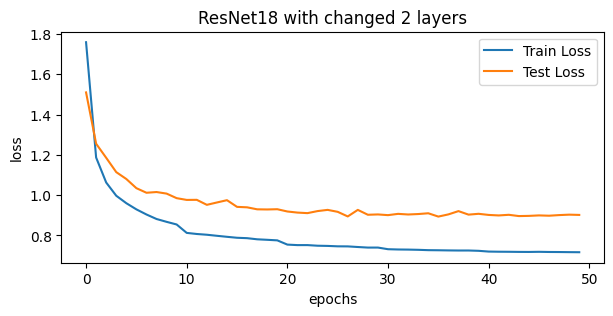

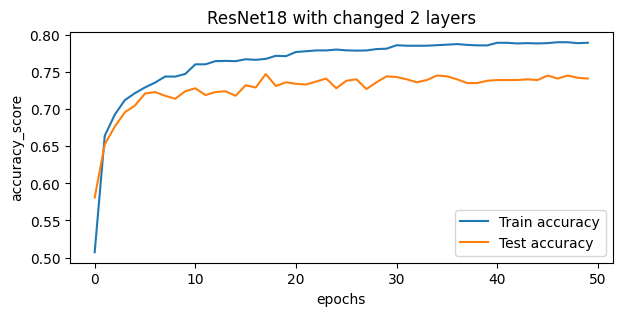

'Accuracy на тестовых данных: 0.74'

In [55]:
plot_charts('ResNet18 with changed 2 layers', tr_l_rn_new, t_l_rn_new, tr_acc_rn_new, t_acc_rn_new)
evaluate(model_RN_new, device, test_loader) 

In [56]:
model_cnnbn = CNNBatchNorm().to(device)
optimizer = torch.optim.AdamW(model_cnnbn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
    
tr_l, t_l, tr_acc, t_acc = train_model(model_cnnbn, device, train_loader, test_loader, 16, optimizer, criterion, writer)

cuda


  6%|▋         | 1/16 [01:24<21:02, 84.17s/it]

Epoch [2/16] Train Loss: 1.4871, Acc: 0.56 | Test Loss: 1.1092, Acc: 0.67


 19%|█▉        | 3/16 [04:14<18:27, 85.17s/it]

Epoch [4/16] Train Loss: 0.6078, Acc: 0.81 | Test Loss: 0.4882, Acc: 0.84


 31%|███▏      | 5/16 [08:06<18:49, 102.64s/it]

Epoch [6/16] Train Loss: 0.1963, Acc: 0.94 | Test Loss: 0.1004, Acc: 0.97


 44%|████▍     | 7/16 [11:01<14:14, 94.92s/it] 

Epoch [8/16] Train Loss: 0.0960, Acc: 0.97 | Test Loss: 0.1470, Acc: 0.95


 56%|█████▋    | 9/16 [13:41<10:09, 87.00s/it]

Epoch [10/16] Train Loss: 0.0621, Acc: 0.98 | Test Loss: 0.0507, Acc: 0.98


 69%|██████▉   | 11/16 [16:28<07:06, 85.35s/it]

Epoch [12/16] Train Loss: 0.0029, Acc: 1.00 | Test Loss: 0.0183, Acc: 1.00


 81%|████████▏ | 13/16 [19:20<04:16, 85.60s/it]

Epoch [14/16] Train Loss: 0.0023, Acc: 1.00 | Test Loss: 0.0047, Acc: 1.00


 94%|█████████▍| 15/16 [21:58<01:22, 82.18s/it]

Epoch [16/16] Train Loss: 0.0019, Acc: 1.00 | Test Loss: 0.0052, Acc: 1.00


100%|██████████| 16/16 [23:16<00:00, 87.29s/it]

Обучение заняло: 1396.69 секунд или: 23.28 минут


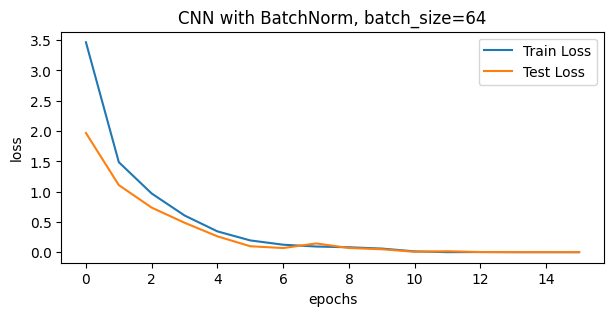

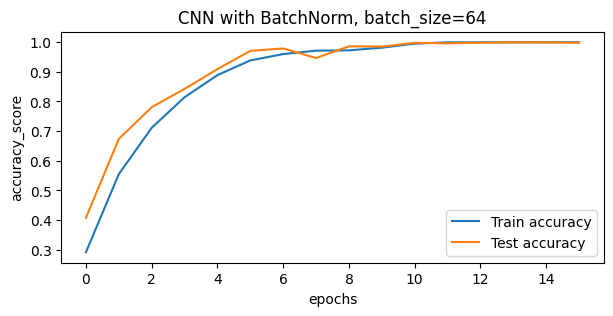

'Accuracy на тестовых данных: 1.00'

In [60]:
plot_charts('CNN with BatchNorm, batch_size=64', tr_l, t_l, tr_acc, t_acc)
evaluate(model_cnnbn, device, test_loader) 

**3.2. Проанализируйте и сравните качество моделей (включая лучшую модель из пункта 2), размер моделей и время инференса моделей на валидационном наборе, сделайте выводы.**

Сравним модели AlexNet, ResNet18 из пункта 3.1.1 и CNNBatchNorm с batch_size = 64.

/tmp/ipykernel_37/3254861428.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_37/3254861428.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


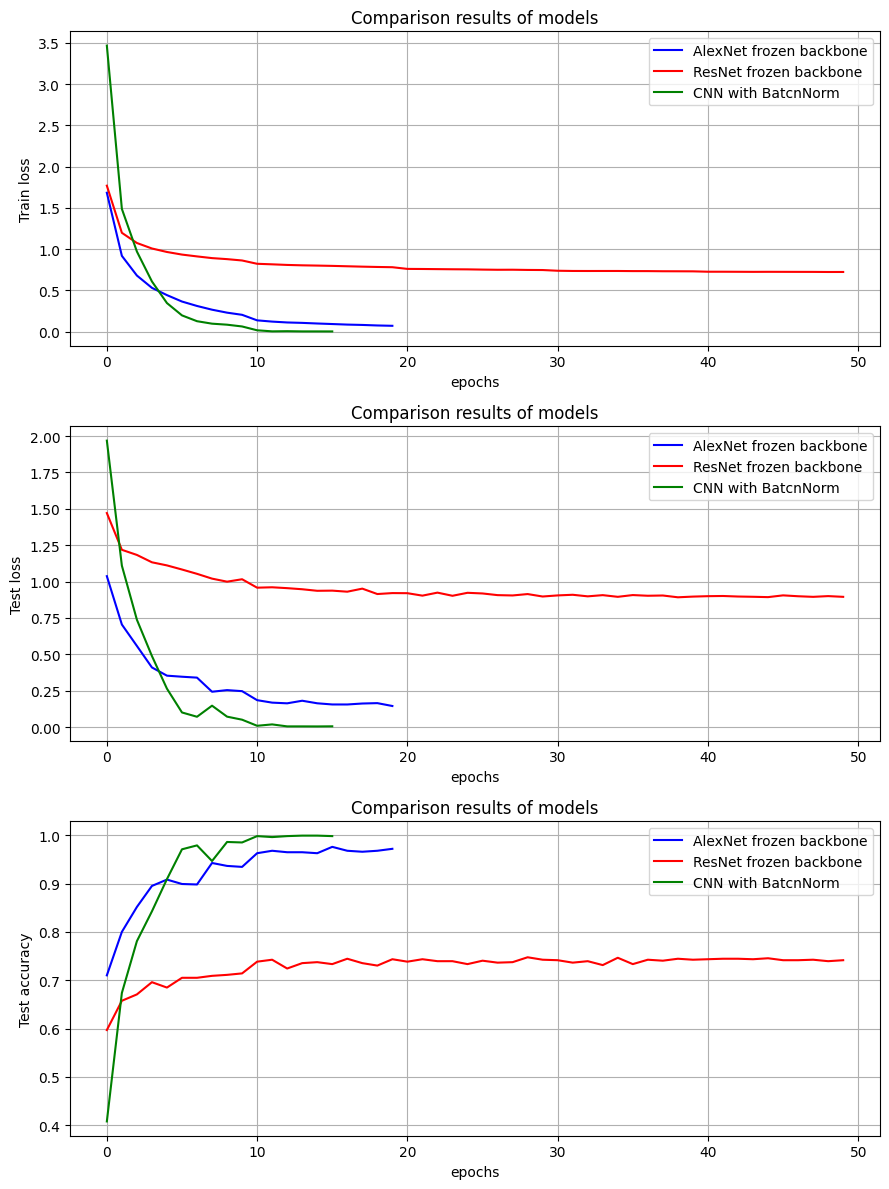

In [61]:
fig, axes = plt.subplots(3, 1, figsize=(9, 12)) 

axes[0].plot(tr_l_an, label="AlexNet frozen backbone", color='blue')
axes[0].plot(tr_l_rn, label="ResNet frozen backbone", color='red')
axes[0].plot(tr_l, label="CNN with BatcnNorm", color='green')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('Train loss')
axes[0].set_title('Comparison results of models') 
axes[0].legend() 
axes[0].grid(True)
plt.tight_layout()

axes[1].plot(t_l_an, label="AlexNet frozen backbone", color='blue')
axes[1].plot(t_l_rn, label="ResNet frozen backbone", color='red')
axes[1].plot(t_l, label="CNN with BatcnNorm", color='green')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('Test loss')
axes[1].set_title('Comparison results of models') 
axes[1].legend() 
axes[1].grid(True)
plt.tight_layout()

axes[2].plot(t_acc_an, label="AlexNet frozen backbone", color='blue')
axes[2].plot(t_acc_rn, label="ResNet frozen backbone", color='red')
axes[2].plot(t_acc, label="CNN with BatcnNorm", color='green')
axes[2].set_xlabel('epochs')
axes[2].set_ylabel('Test accuracy')
axes[2].set_title('Comparison results of models') 
axes[2].legend() 
axes[2].grid(True)
plt.tight_layout()

plt.show()

Модели обучались на разном количестве эпох, так как например для CNNBatchNorm и AlexNet достаточно 16 или 20 эпох, а ResNet обучается хуже и дольше. По результатам экспериментов, CNN with BatchNorm лучше классифицирует симпсонов.

Сравним модели AlexNet, ResNet18 из пункта 3.1.2 и CNNBatchNorm с batch_size = 64.

/tmp/ipykernel_37/4039748224.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_37/4039748224.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


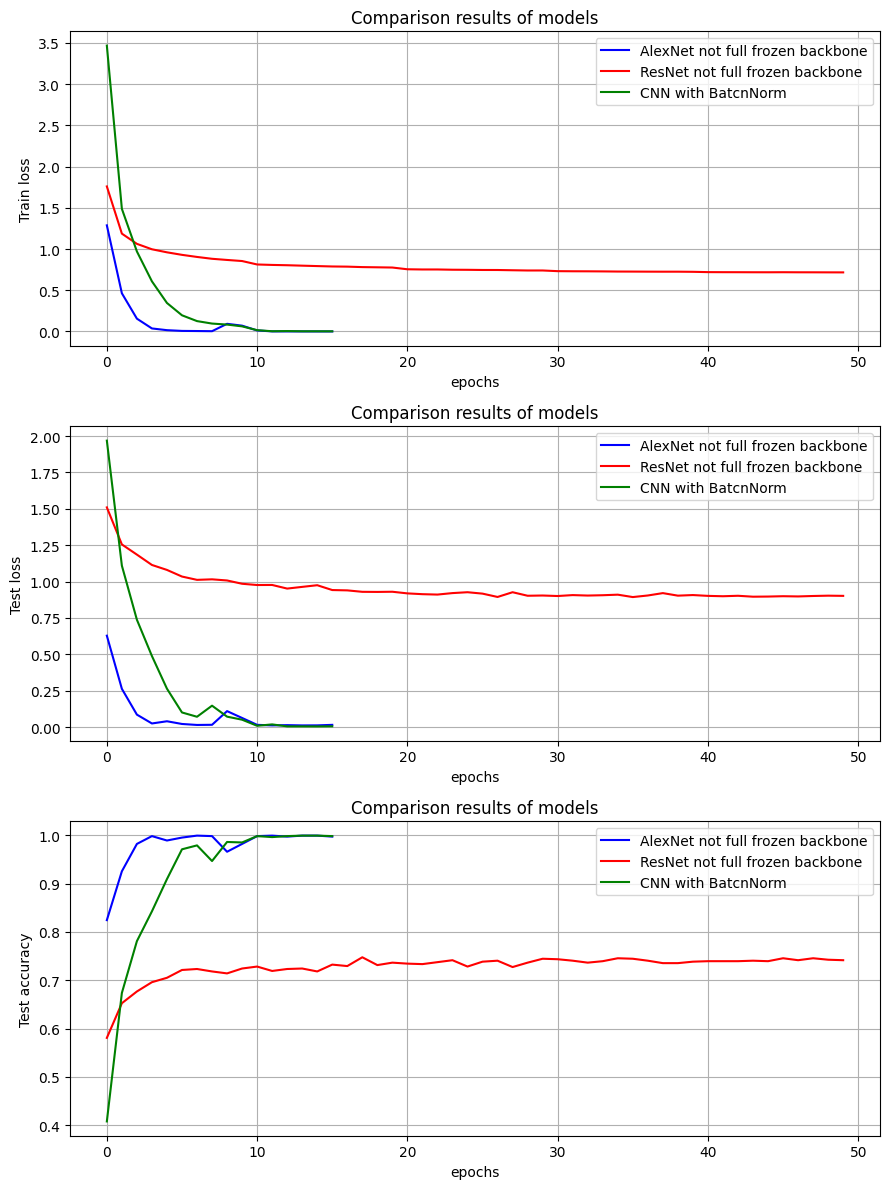

In [63]:
fig, axes = plt.subplots(3, 1, figsize=(9, 12)) 

axes[0].plot(tr_l_an_new, label="AlexNet not full frozen backbone", color='blue')
axes[0].plot(tr_l_rn_new, label="ResNet not full frozen backbone", color='red')
axes[0].plot(tr_l, label="CNN with BatcnNorm", color='green')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('Train loss')
axes[0].set_title('Comparison results of models') 
axes[0].legend() 
axes[0].grid(True)
plt.tight_layout()

axes[1].plot(t_l_an_new, label="AlexNet not full frozen backbone", color='blue')
axes[1].plot(t_l_rn_new, label="ResNet not full frozen backbone", color='red')
axes[1].plot(t_l, label="CNN with BatcnNorm", color='green')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('Test loss')
axes[1].set_title('Comparison results of models') 
axes[1].legend() 
axes[1].grid(True)
plt.tight_layout()

axes[2].plot(t_acc_an_new, label="AlexNet not full frozen backbone", color='blue')
axes[2].plot(t_acc_rn_new, label="ResNet not full frozen backbone", color='red')
axes[2].plot(t_acc, label="CNN with BatcnNorm", color='green')
axes[2].set_xlabel('epochs')
axes[2].set_ylabel('Test accuracy')
axes[2].set_title('Comparison results of models') 
axes[2].legend() 
axes[2].grid(True)
plt.tight_layout()

plt.show()

В данном случае AlexNet в результате показывает схожим результаты с CNNBatchNorm, ResNet остает в обоих случаях. Модель AlexNet обучается быстрее всех.

Сравним время моделей на инференсе.

In [67]:
start_time = time.time()
print(evaluate(model_AN, device, test_loader))
end_time = time.time()
print(f"Время инференса модели AlexNet with frozen backbone {end_time-start_time}")

start_time = time.time()
print(evaluate(model_RN, device, test_loader))
end_time = time.time()
print(f"Время инференса модели ResNet with frozen backbone {end_time-start_time}")

start_time = time.time()
print(evaluate(model_cnnbn, device, test_loader))
end_time = time.time()
print(f"Время инференса модели CNN with BatchNorm {end_time-start_time}")

start_time = time.time()
print(evaluate(model_AN_new, device, test_loader))
end_time = time.time()
print(f"Время инференса модели AlexNet with not full frozen backbone {end_time-start_time}")


start_time = time.time()
print(evaluate(model_RN_new, device, test_loader))
end_time = time.time()
print(f"Время инференса модели ResNet with not full frozen backbone {end_time-start_time}")


Accuracy на тестовых данных: 0.97
Время инференса модели AlexNet with frozen backbone 1.9781296253204346
Accuracy на тестовых данных: 0.74
Время инференса модели ResNet with frozen backbone 2.134714365005493
Accuracy на тестовых данных: 1.00
Время инференса модели CNN with BatchNorm 2.045050621032715
Accuracy на тестовых данных: 1.00
Время инференса модели AlexNet with not full frozen backbone 1.8567073345184326
Accuracy на тестовых данных: 0.74
Время инференса модели ResNet with not full frozen backbone 2.01902437210083


ResNet в среднем имеет бОльшее время на инференсе, CNNBatchNorm чуть быстрее работает, а самая быстрая модель AlexNet.